# Coursework 2: Generative Models

## Instructions

### Submission 
Please submit one zip file on cate - *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells**
2. Your trained VAE model as *VAE_model.pth*
3. Your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*


### Training
Training the GAN will take quite a long time (multiple hours), please refer to the 4 GPU options detailed in the logistics lecture. Some additional useful pointers:
* PaperSpace [guide if you need more compute](https://hackmd.io/@afspies/S1stL8Qnt)
* Lab GPUs via SSH.  The VSCode Remote Develop extension is recommended for this. For general Imperial remote working instructions see [this post](https://www.doc.ic.ac.uk/~nuric/teaching/remote-working-for-imperial-computing-students.html). You'll also want to [setup your environment as outlined here](https://hackmd.io/@afspies/Bkd7Zq60K).
* Use Colab and add checkpointing to the model training code; this is to handle the case where colab stops a free-GPU kernel after a certain number of hours (~4).
* Use Colab Pro - If you do not wish to use PaperSpace then you can pay for Colab Pro. We cannot pay for this on your behalf (this is Google's fault).


### Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions)

### General
You can feel free to add architectural alterations / custom functions outside of pre-defined code blocks, but if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

<font color="orange">**The deadline for submission is Monday, 26 Feb by 6 pm** </font>

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [1]:
#!pip install -q torch torchvision altair seaborn
#!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [2]:
# Initialization Cell
WORKING_ENV = "MAC"  # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
USERNAME = ""  # If working on Lab Machines - Your college username
assert WORKING_ENV in ["LABS", "COLAB", "PAPERSPACE", "SAGEMAKER", "MAC"]

if WORKING_ENV == "COLAB":
    from google.colab import drive

    %load_ext google.colab.data_table
    dl_cw2_repo_path = "dl_cw2/"  # path in your gdrive to the repo
    content_path = f"/content/drive/MyDrive/{dl_cw2_repo_path}"  # path to gitrepo in gdrive after mounting
    data_path = "./data/"  # save the data locally
    drive.mount("/content/drive/")  # Outputs will be saved in your google drive

elif WORKING_ENV == "LABS":
    content_path = (
        f"/vol/bitbucket/{USERNAME}/dl/dl_cw2/"  # You may want to change this
    )
    data_path = f"/vol/bitbucket/{USERNAME}/dl/"
    # Your python env and training data should be on bitbucket
    if "vol/bitbucket" not in content_path or "vol/bitbucket" not in data_path:
        import warnings

        warnings.warn(
            "It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues"
        )
elif WORKING_ENV == "PAPERSPACE":  # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = "/notebooks/"
    data_path = "./data/"

elif WORKING_ENV == "SAGEMAKER":
    content_path = "/home/studio-lab-user/sagemaker-studiolab-notebooks/dl/"
    data_path = f"{content_path}data/"

elif WORKING_ENV == "MAC":
    content_path = "/Users/savrajsian/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Documents/Deep Learning/CW2/"
    data_path = f"{content_path}data/"
else:
    raise NotImplementedError()

content_path = Path(content_path)

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points. 

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. More marks are awarded for using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [57]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


if not os.path.exists(content_path / "CW_VAE/"):
    os.makedirs(content_path / "CW_VAE/")

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = 1  # Choose whether to use GPU
if GPU:
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
else:
    device = torch.device("cpu")
print(f"Using {device}")

Using mps


---
## Part 1.1a: Implement VAE (25 Points)
### Hyper-parameter selection


In [80]:
# Necessary Hyperparameters
num_epochs = 12
learning_rate = 0.005
batch_size = 64
latent_dim = 16  # Choose a value for the size of the latent space

# Additional Hyperparameters

kl_beta = 1.5  # KL divergence annealing
loss_fn = nn.BCELoss(reduction="sum")

# (Optionally) Modify transformations on input
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # already normalizes to [0,1]
        lambda x: x.round(),
    ]
)


# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [59]:
train_dat = datasets.MNIST(data_path, train=True, download=True, transform=transform)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path / "CW_VAE/image_original.png")

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


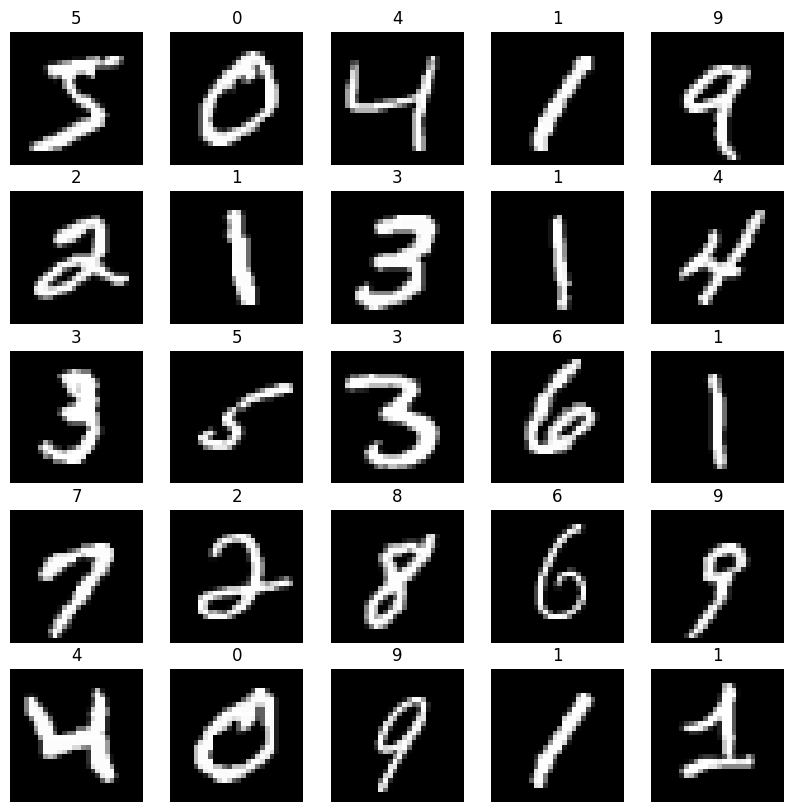

In [60]:
# get number of images per class

print(train_dat.targets.bincount())

# Visualize the data
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis("off")
    plt.imshow(train_dat.data[i], cmap="gray")
    plt.title(train_dat.targets[i].item())
plt.show()

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [81]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.epochs = num_epochs
        self.lr = learning_rate
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.device = device

        # convolutional encoder
        self.encoder = nn.Sequential(  # in 1x28x28
            nn.Conv2d(
                in_channels=1, out_channels=8, kernel_size=4, stride=2, padding=1
            ),  # 4x14x14
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1
            ),  # 16x7x7
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1
            ),  # 32x4x4
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1
            ),  # 64x2x2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )

        self.fc_mu = nn.Linear(256, self.latent_dim)
        self.fc_logvar = nn.Linear(256, self.latent_dim)

        self.linear_enc = nn.Linear(64, 256)
        self.linear_dec = nn.Linear(self.latent_dim, 64)
        self.linear_relu = nn.LeakyReLU()
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # deconvolutional decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64, out_channels=64, kernel_size=4
            ),  # 32x4x4
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1
            ),  # 16x7x7
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=32, out_channels=8, kernel_size=4, stride=2, padding=1
            ),  # 8x14x14
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1
            ),  # 1x28x28
            nn.Sigmoid(),
        )

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # go from mnist image to latent space - use convolution
        # conv2d, batchnorm, activ
        # going from mnist 28x28 to latent_dim
        x = self.encoder(x)
        x = self.avgpool(x)  # for transition to linear layer
        x = x.view(x.size(0), -1)  # reshape for linear layer, remove extra dims
        x = self.linear_enc(x)
        x = self.linear_relu(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # sample from standard gaussian
        eps = torch.randn_like(logvar)
        z = mu + torch.exp(0.5 * logvar) * eps  # logvar to std
        return z

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        z = self.linear_dec(z)
        z = z.view(-1, 64, 1, 1)  # reshape for CNN
        z = self.decoder(z)
        return z

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # encode

        # x = self.t1(x)
        # print(x.shape)
        # x = self.t2(x)
        # print(x.shape)
        # x = self.t3(x)
        # print('after t', x.shape)

        mu, var = self.encode(x)
        # print('mu var', mu, var)
        # reparametrize
        z = self.reparametrize(mu, var)
        # print('z', z)
        # decode
        x_hat = self.decode(z)
        # print('x_hat', x_hat)
        return x_hat, mu, var

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################


model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 154369
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (fc_mu): Linear(in_features=256, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=256, out_features

In [62]:
from torchsummary import summary

summarymodel = VAE(latent_dim)  # needs to be on cpu
summary(summarymodel, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]             136
       BatchNorm2d-2            [-1, 8, 14, 14]              16
         LeakyReLU-3            [-1, 8, 14, 14]               0
            Conv2d-4             [-1, 16, 7, 7]           2,064
       BatchNorm2d-5             [-1, 16, 7, 7]              32
         LeakyReLU-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 4, 4]           4,640
       BatchNorm2d-8             [-1, 32, 4, 4]              64
         LeakyReLU-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 2, 2]          32,832
      BatchNorm2d-11             [-1, 64, 2, 2]             128
        LeakyReLU-12             [-1, 64, 2, 2]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14                  [

--- 

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [82]:
# *CODE FOR PART 1.1b IN THIS CELL*


def loss_function_VAE(recon_x, x, mu, logvar, beta):
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################

    # reconstruction loss
    # print(recon_x.shape, x.shape)
    recon_loss = loss_fn(recon_x, x)
    # print('rec', recon_loss.item())
    # assuming standard normal prior z ~ N(0, I)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print(recon_loss, kl_div)
    # kl_loss = kl_div.mean()
    kl_loss = kl_div
    # print('kll', kl_loss.item())
    # print('kld', kl_div)

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################


model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

model.train()  # already on device here
train_losses = []
test_losses = []

do_test = True
print("using device ", device)
print("beta =", kl_beta)

num_steps = num_epochs * len(loader_train)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True, factor=0.5)
lam = lambda epoch: 0.8 * epoch
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=0.8, verbose=True
)

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    print("in epoch ", epoch, "/", num_epochs - 1)
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        track_losses = np.array([0, 0, 0])
        total_batches = 0
        for batch_idx, (data, _) in enumerate(tepoch):
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # data = None # Need at least one batch/random data with right shape -
            # This is required to initialize to model properly below
            # when we save the computational graph for testing (jit.save)
            # loss = None
            model.train()
            data = data.to(device)
            model_out, mu, var = model(data)
            # print('mout',model_out)
            loss, recon_loss, kl_loss = loss_function_VAE(
                model_out, data, mu, var, kl_beta
            )

            if batch_idx % 200 == 0:
                print(
                    "loss: ",
                    loss.item(),
                    "    recon loss: ",
                    recon_loss.item(),
                    "    kl loss: ",
                    kl_loss.item(),
                )

                # print('curr lr: ', lr_scheduler.get_last_lr())
                # lr_scheduler.step(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            track_losses[0] += loss.item()
            track_losses[1] += recon_loss.item()
            track_losses[2] += kl_loss.item()
            total_batches += 1

        track_losses = track_losses / total_batches
        train_losses.append((track_losses[0], track_losses[1], track_losses[2]))
        print(f"avg training losses for epoch {epoch} is {track_losses}")

        lr_scheduler.step()

        if do_test:
            model.eval()
            with torch.no_grad():
                track_losses = np.array([0, 0, 0])
                total_batches = 0
                for test_idx, (test_data, _test) in enumerate(loader_test):
                    test_data = test_data.to(device)
                    test_model_out, test_mu, test_var = model(test_data)
                    test_loss, test_recon, test_kl = loss_function_VAE(
                        test_model_out, test_data, test_mu, test_var, kl_beta
                    )
                    track_losses[0] += test_loss.item()
                    track_losses[1] += test_recon.item()
                    track_losses[2] += test_kl.item()
                    total_batches += 1

            track_losses = track_losses / total_batches
            test_losses.append((track_losses[0], track_losses[1], track_losses[2]))

            print(f"avg val losses for epoch {epoch} is {track_losses}")

            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item() / len(data))

    # save the model
    if epoch == num_epochs - 1:
        with torch.no_grad():
            torch.jit.save(
                torch.jit.trace(model, (data), check_trace=False),
                content_path / "CW_VAE/VAE_model.pth",
            )

using device  mps
beta = 1.5
Adjusting learning rate of group 0 to 5.0000e-03.
in epoch  0 / 11


  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 3/938 [00:00<00:37, 24.67batch/s]

loss:  40790.59375     recon loss:  40771.12890625     kl loss:  12.977776527404785


 22%|██▏       | 204/938 [00:05<00:18, 40.73batch/s]

loss:  11613.3154296875     recon loss:  11103.865234375     kl loss:  339.6334533691406


 43%|████▎     | 406/938 [00:10<00:13, 40.26batch/s]

loss:  9725.0390625     recon loss:  9042.908203125     kl loss:  454.754150390625


 65%|██████▍   | 606/938 [00:15<00:08, 40.30batch/s]

loss:  10060.60546875     recon loss:  9341.708984375     kl loss:  479.26409912109375


 86%|████████▌ | 806/938 [00:20<00:03, 40.35batch/s]

loss:  9834.37890625     recon loss:  9063.3740234375     kl loss:  514.0031127929688


100%|██████████| 938/938 [00:23<00:00, 40.36batch/s]


avg training losses for epoch 0 is [10484.03518124  9847.55970149   423.82089552]
Adjusting learning rate of group 0 to 4.0000e-03.
avg val losses for epoch 0 is [8842.14649682 8067.49044586  515.94267516]
in epoch  1 / 11


  0%|          | 4/938 [00:00<00:26, 35.25batch/s]

loss:  8477.1103515625     recon loss:  7689.61474609375     kl loss:  524.9970092773438


 22%|██▏       | 207/938 [00:04<00:17, 42.27batch/s]

loss:  8651.4580078125     recon loss:  7817.0009765625     kl loss:  556.3046875


 43%|████▎     | 407/938 [00:09<00:12, 42.29batch/s]

loss:  8313.0439453125     recon loss:  7486.84619140625     kl loss:  550.7982177734375


 65%|██████▍   | 607/938 [00:14<00:07, 41.96batch/s]

loss:  8093.7119140625     recon loss:  7267.818359375     kl loss:  550.5958251953125


 86%|████████▌ | 806/938 [00:19<00:03, 41.95batch/s]

loss:  8236.8876953125     recon loss:  7371.6044921875     kl loss:  576.8555297851562


100%|██████████| 938/938 [00:22<00:00, 41.99batch/s]


avg training losses for epoch 1 is [8646.4434968  7821.78464819  549.26012793]
Adjusting learning rate of group 0 to 3.2000e-03.
avg val losses for epoch 1 is [8366.87261146 7498.63694268  578.31210191]
in epoch  2 / 11


  0%|          | 4/938 [00:00<00:23, 39.08batch/s]

loss:  9275.400390625     recon loss:  8389.69921875     kl loss:  590.46728515625


 22%|██▏       | 204/938 [00:04<00:17, 41.53batch/s]

loss:  7852.5947265625     recon loss:  7042.33837890625     kl loss:  540.1709594726562


 43%|████▎     | 404/938 [00:09<00:12, 41.99batch/s]

loss:  8370.986328125     recon loss:  7451.15478515625     kl loss:  613.220947265625


 64%|██████▍   | 604/938 [00:14<00:08, 41.46batch/s]

loss:  8304.3857421875     recon loss:  7427.033203125     kl loss:  584.9017944335938


 86%|████████▌ | 804/938 [00:19<00:03, 41.78batch/s]

loss:  8134.9375     recon loss:  7184.6259765625     kl loss:  633.5409545898438


100%|██████████| 938/938 [00:22<00:00, 41.87batch/s]


avg training losses for epoch 2 is [8249.8901919  7359.86567164  592.85714286]
Adjusting learning rate of group 0 to 2.5600e-03.
avg val losses for epoch 2 is [7969.15923567 7021.57324841  631.21019108]
in epoch  3 / 11


  0%|          | 4/938 [00:00<00:24, 37.39batch/s]

loss:  8131.14794921875     recon loss:  7158.4462890625     kl loss:  648.4676513671875


 22%|██▏       | 207/938 [00:04<00:17, 42.02batch/s]

loss:  7847.013671875     recon loss:  6895.97265625     kl loss:  634.0274658203125


 43%|████▎     | 407/938 [00:09<00:12, 41.41batch/s]

loss:  7868.01025390625     recon loss:  6841.50830078125     kl loss:  684.3345336914062


 65%|██████▍   | 607/938 [00:14<00:08, 41.23batch/s]

loss:  7656.5947265625     recon loss:  6683.2724609375     kl loss:  648.8814086914062


 86%|████████▌ | 807/938 [00:19<00:03, 41.38batch/s]

loss:  7493.025390625     recon loss:  6491.43994140625     kl loss:  667.7236328125


100%|██████████| 938/938 [00:22<00:00, 41.36batch/s]


avg training losses for epoch 3 is [7868.27398721 6873.57889126  662.63219616]
Adjusting learning rate of group 0 to 2.0480e-03.
avg val losses for epoch 3 is [7581.23566879 6579.31847134  667.42038217]
in epoch  4 / 11


  0%|          | 4/938 [00:00<00:24, 38.37batch/s]

loss:  7822.8212890625     recon loss:  6833.8740234375     kl loss:  659.2980346679688


 22%|██▏       | 207/938 [00:05<00:17, 41.82batch/s]

loss:  7815.6455078125     recon loss:  6774.95654296875     kl loss:  693.7926025390625


 43%|████▎     | 407/938 [00:09<00:12, 42.00batch/s]

loss:  7550.43212890625     recon loss:  6525.9287109375     kl loss:  683.0022583007812


 65%|██████▍   | 607/938 [00:14<00:07, 41.74batch/s]

loss:  7780.02880859375     recon loss:  6766.279296875     kl loss:  675.8331298828125


 86%|████████▌ | 807/938 [00:19<00:03, 41.71batch/s]

loss:  7831.4697265625     recon loss:  6808.65185546875     kl loss:  681.8784790039062


100%|██████████| 938/938 [00:22<00:00, 41.51batch/s]


avg training losses for epoch 4 is [7632.5021322  6606.68763326  683.38592751]
Adjusting learning rate of group 0 to 1.6384e-03.
avg val losses for epoch 4 is [7466.70700637 6421.87898089  696.01910828]
in epoch  5 / 11


  0%|          | 4/938 [00:00<00:24, 38.56batch/s]

loss:  7553.8095703125     recon loss:  6526.74951171875     kl loss:  684.7066650390625


 22%|██▏       | 207/938 [00:05<00:17, 41.82batch/s]

loss:  7714.7919921875     recon loss:  6652.484375     kl loss:  708.2049560546875


 43%|████▎     | 407/938 [00:09<00:12, 41.90batch/s]

loss:  6675.72119140625     recon loss:  5675.275390625     kl loss:  666.9639282226562


 65%|██████▍   | 607/938 [00:14<00:07, 41.54batch/s]

loss:  7082.94482421875     recon loss:  6043.328125     kl loss:  693.0778198242188


 86%|████████▌ | 807/938 [00:19<00:03, 41.24batch/s]

loss:  7356.7705078125     recon loss:  6331.53125     kl loss:  683.4928588867188


100%|██████████| 938/938 [00:22<00:00, 41.25batch/s]


avg training losses for epoch 5 is [7502.30703625 6454.89658849  697.80170576]
Adjusting learning rate of group 0 to 1.3107e-03.
avg val losses for epoch 5 is [7363.61783439 6324.61146497  692.17197452]
in epoch  6 / 11


  0%|          | 4/938 [00:00<00:24, 38.55batch/s]

loss:  7453.69189453125     recon loss:  6434.9013671875     kl loss:  679.1937255859375


 22%|██▏       | 207/938 [00:05<00:17, 41.26batch/s]

loss:  7432.623046875     recon loss:  6403.923828125     kl loss:  685.7996826171875


 43%|████▎     | 407/938 [00:09<00:12, 41.67batch/s]

loss:  7148.185546875     recon loss:  6050.10302734375     kl loss:  732.0550537109375


 65%|██████▍   | 606/938 [00:14<00:08, 41.08batch/s]

loss:  7759.5126953125     recon loss:  6679.275390625     kl loss:  720.1583251953125


 86%|████████▌ | 806/938 [00:19<00:03, 39.89batch/s]

loss:  6967.8212890625     recon loss:  5883.162109375     kl loss:  723.1060791015625


100%|██████████| 938/938 [00:22<00:00, 41.01batch/s]


avg training losses for epoch 6 is [7399.15565032 6337.36460554  707.35607676]
Adjusting learning rate of group 0 to 1.0486e-03.
avg val losses for epoch 6 is [7274.75796178 6216.11464968  705.23566879]
in epoch  7 / 11


  0%|          | 4/938 [00:00<00:24, 38.70batch/s]

loss:  6896.76806640625     recon loss:  5816.9287109375     kl loss:  719.8930053710938


 22%|██▏       | 207/938 [00:05<00:17, 41.65batch/s]

loss:  7196.359375     recon loss:  6130.8037109375     kl loss:  710.3703002929688


 43%|████▎     | 407/938 [00:09<00:12, 41.48batch/s]

loss:  7003.73486328125     recon loss:  5950.7255859375     kl loss:  702.006103515625


 65%|██████▍   | 606/938 [00:14<00:08, 41.47batch/s]

loss:  7475.9873046875     recon loss:  6406.38818359375     kl loss:  713.0659790039062


 86%|████████▌ | 806/938 [00:19<00:03, 40.63batch/s]

loss:  7732.033203125     recon loss:  6667.974609375     kl loss:  709.372314453125


100%|██████████| 938/938 [00:22<00:00, 40.98batch/s]


avg training losses for epoch 7 is [7336.87633262 6264.6652452   714.30383795]
Adjusting learning rate of group 0 to 8.3886e-04.
avg val losses for epoch 7 is [7228.22292994 6151.82802548  717.07006369]
in epoch  8 / 11


  0%|          | 4/938 [00:00<00:24, 38.19batch/s]

loss:  7279.2626953125     recon loss:  6193.126953125     kl loss:  724.0903930664062


 22%|██▏       | 207/938 [00:05<00:17, 41.56batch/s]

loss:  7258.7138671875     recon loss:  6213.36669921875     kl loss:  696.898193359375


 43%|████▎     | 407/938 [00:09<00:12, 41.16batch/s]

loss:  7459.068359375     recon loss:  6369.33349609375     kl loss:  726.48974609375


 64%|██████▍   | 605/938 [00:14<00:08, 41.13batch/s]

loss:  7125.41455078125     recon loss:  6076.818359375     kl loss:  699.064208984375


 86%|████████▌ | 805/938 [00:19<00:03, 41.60batch/s]

loss:  7248.11279296875     recon loss:  6148.14599609375     kl loss:  733.3112182617188


100%|██████████| 938/938 [00:22<00:00, 41.18batch/s]


avg training losses for epoch 8 is [7278.78464819 6199.64498934  718.90298507]
Adjusting learning rate of group 0 to 6.7109e-04.
avg val losses for epoch 8 is [7179.84076433 6100.49044586  719.01273885]
in epoch  9 / 11


  0%|          | 4/938 [00:00<00:24, 37.73batch/s]

loss:  7361.10546875     recon loss:  6284.09765625     kl loss:  718.0051879882812


 22%|██▏       | 206/938 [00:05<00:17, 41.63batch/s]

loss:  7474.0947265625     recon loss:  6366.3544921875     kl loss:  738.4934692382812


 43%|████▎     | 406/938 [00:09<00:12, 41.12batch/s]

loss:  6797.5029296875     recon loss:  5698.4912109375     kl loss:  732.6746826171875


 64%|██████▍   | 605/938 [00:14<00:08, 41.11batch/s]

loss:  7105.462890625     recon loss:  6023.5146484375     kl loss:  721.2986450195312


 86%|████████▌ | 805/938 [00:19<00:03, 40.77batch/s]

loss:  7163.2919921875     recon loss:  6095.037109375     kl loss:  712.169921875


100%|██████████| 938/938 [00:22<00:00, 41.04batch/s]


avg training losses for epoch 9 is [7238.43390192 6152.19509595  723.67164179]
Adjusting learning rate of group 0 to 5.3687e-04.
avg val losses for epoch 9 is [7167.17834395 6083.33757962  722.08917197]
in epoch  10 / 11


  0%|          | 4/938 [00:00<00:24, 38.09batch/s]

loss:  7446.5341796875     recon loss:  6349.388671875     kl loss:  731.430419921875


 22%|██▏       | 206/938 [00:05<00:17, 41.02batch/s]

loss:  7450.28369140625     recon loss:  6345.9443359375     kl loss:  736.226318359375


 43%|████▎     | 406/938 [00:09<00:12, 41.73batch/s]

loss:  7398.712890625     recon loss:  6343.88671875     kl loss:  703.2174682617188


 65%|██████▍   | 606/938 [00:14<00:08, 41.44batch/s]

loss:  6911.70166015625     recon loss:  5804.626953125     kl loss:  738.0498046875


 86%|████████▌ | 806/938 [00:19<00:03, 40.25batch/s]

loss:  7054.86669921875     recon loss:  5987.09423828125     kl loss:  711.8482666015625


100%|██████████| 938/938 [00:22<00:00, 41.06batch/s]


avg training losses for epoch 10 is [7203.39232409 6114.49360341  725.43283582]
Adjusting learning rate of group 0 to 4.2950e-04.
avg val losses for epoch 10 is [7137.8343949  6047.74522293  726.22929936]
in epoch  11 / 11


  0%|          | 4/938 [00:00<00:23, 39.19batch/s]

loss:  7043.7353515625     recon loss:  5931.181640625     kl loss:  741.7025146484375


 22%|██▏       | 208/938 [00:05<00:17, 41.27batch/s]

loss:  7052.59765625     recon loss:  5935.853515625     kl loss:  744.49609375


 43%|████▎     | 408/938 [00:09<00:12, 41.02batch/s]

loss:  6753.875     recon loss:  5651.5830078125     kl loss:  734.861328125


 65%|██████▍   | 607/938 [00:14<00:08, 41.17batch/s]

loss:  6914.2646484375     recon loss:  5824.2119140625     kl loss:  726.7018432617188


 86%|████████▌ | 807/938 [00:19<00:03, 41.54batch/s]

loss:  6614.48046875     recon loss:  5526.048828125     kl loss:  725.6212158203125


100%|██████████| 938/938 [00:22<00:00, 41.09batch/s]


avg training losses for epoch 11 is [7178.47547974 6082.70469083  730.01918977]
Adjusting learning rate of group 0 to 3.4360e-04.
avg val losses for epoch 11 is [7113.67515924 6017.98089172  729.97452229]


### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


**YOUR ANSWER**


The Beta-VAE loss consists of the reconstruction loss, calculated using binary cross entropy, and the KL divergence between the latent variable's prior, assumed to be a standard gaussian, and the learned distribution. A Gaussian is a suitable assumption to make since there are a large number of samples and the central limit theorem states that as the sample size increases, the distribution will converge to a normal distribution. Also, due to the law of large numbers, as the sample size grows the sample mean will approach the true mean. In the calculation of the reconstruction loss, a Monte Carlo approach is used to calculate the expectation and analytic form for the KL distribution is used (along with the assumption that $p(z) = N(z;0,I)$). The parameterization trick is needed to allow the automatic differentiation of the loss function. I chose to use reduction='sum' in the BCE loss as it yielded much better results than when I used reduction='mean', possibly due to it provides a larger loss value to be used in updates. 

The output data domain is normalised between 0 and 1 as binary cross entropy is used in the reconstruction loss; when the ToTensor() transform is used, the train and test data is automatically restricted between 0 and 1. I rounded the pixel values to be 0 or 1 to allow the BCE loss function to work better and simplify the learning for the model; this change improved the performance of the model.

The KL term penalizes deviations of the latent variable distributions from the prior distribution (standard Gaussian) to encourage the latent space to have a more structured form. This also promotes diversity in the representations of each digit across the latent space so that different digits are encoded to different areas of the latent space so that the representations are actually meaningful in terms of their place in the latent space.
The KL term also leads to better disentanglement in the latent space, and the degree of disentanglement is controlled by $\beta$, where a lower $\beta$ prioritizes reconstruction loss over the KL divergence term, whereas a higher $\beta$ value places greater emphasis on the KL divergence term in the loss. A $\beta > 1$ means the model is encouraged to learn a more efficient, disentangled latent representation of the data. A main benefit of a more disentangled representation is improved generative performance since in a disentangled representation, knowledge of one specific factor can be effectively applied to new combinations of other factors.



<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

<function matplotlib.pyplot.show(close=None, block=None)>

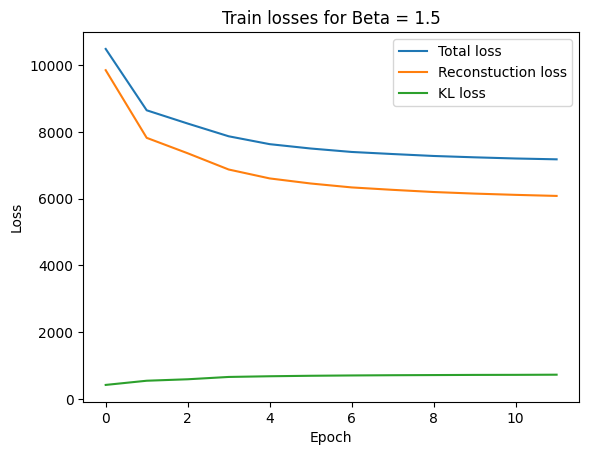

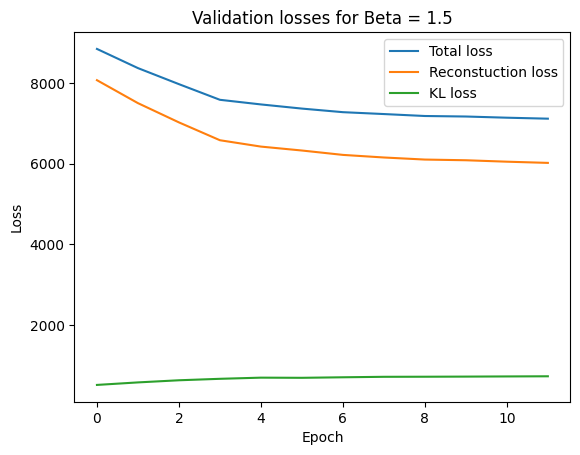

In [85]:
# *CODE FOR PART 1.2a IN THIS CELL*

plt.figure()
plt.plot(train_losses)
plt.legend(("Total loss", "Reconstuction loss", "KL loss"))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train losses for Beta = 1.5")
plt.savefig("train_losses_beta1point5")
plt.show

plt.figure()
plt.plot(test_losses)
plt.legend(("Total loss", "Reconstuction loss", "KL loss"))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation losses for Beta = 1.5")
plt.savefig("val_losses_beta1point5")
plt.show

Plots for other beta values:

![trainloss0point5](VAE%20figs/train_losses_beta0point5.png)
![val_losses_beta0point5.png](VAE%20figs/val_losses_beta0point5.png)


![train_losses_beta2.png](VAE%20figs/train_losses_beta2.png)
![val_losses_beta1.png](VAE%20figs/val_losses_beta1.png)

![train_losses_beta5.png](VAE%20figs/train_losses_beta5.png)
![val_losses_beta5.png](VAE%20figs/val_losses_beta5.png)

## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


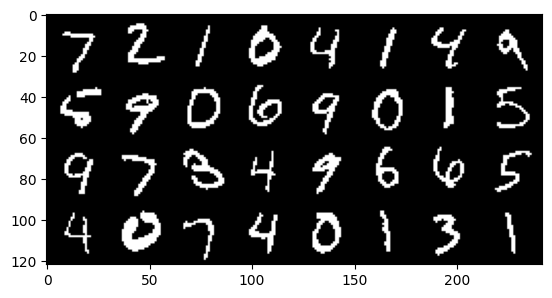

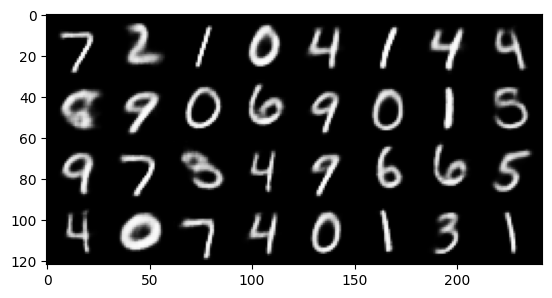

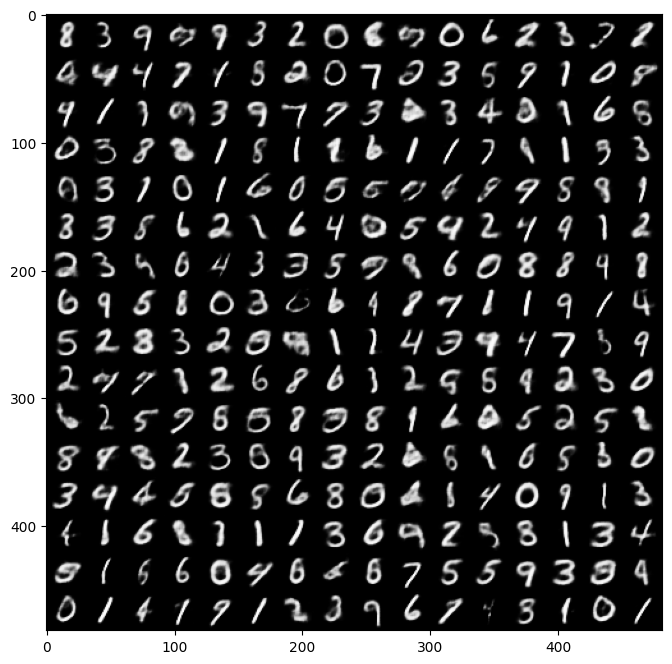

In [86]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print("Input images")
print("-" * 50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(
    denorm(fixed_input),
    nrow=8,
    padding=2,
    normalize=False,
    value_range=None,
    scale_each=False,
    pad_value=0,
)
plt.figure()
show(img)

print("Reconstructed images")
print("-" * 50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, mu, var = model(fixed_input.to(device))
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(
        denorm(recon_batch),
        nrow=8,
        padding=2,
        normalize=False,
        value_range=None,
        scale_each=False,
        pad_value=0,
    )
    plt.figure()
    show(recon_batch)

print("Generated Images")
print("-" * 50)
model.eval()
n_samples = 256
z = torch.randn(n_samples, latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################

    samples = model.decode(z)

    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    samples = samples.cpu()
    samples = make_grid(
        denorm(samples),
        nrow=16,
        padding=2,
        normalize=False,
        value_range=None,
        scale_each=False,
        pad_value=0,
    )
    plt.figure(figsize=(8, 8))
    show(samples)

### Discussion
Provide a brief analysis of your loss curves and reconstructions: 
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable? 
* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)? 
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

In all of the loss graphs, the reconstruction (log-likelihood) loss is decreasing and then plateaus, the KL loss increases and plateaus and the total loss follows a similar behaviour to the reconstruction loss. This behaviour is expected, as when looking at the loss function, $ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$, we can see that to minimise this we can either decrease the reconstruction loss or increase the KL loss. Since both of these are happening to minimise the overall loss, the observed behaviour is desirable. The total loss decreases as the $\beta$ value is increased as the KL loss magnitude increases. 

Posterior collapse is where the learned posterior distribution collapses to the prior (in this case a standard Gaussian) which reduces the capacity of the posterior to give useful information for the decoder to make use of. The decoder is in this case forced to almost ignore the specific z inputs and produce a generic output, often representative of multiple image classes (in this case digits). I did not see any posterior collapse in my training, presumably due to the fact that the KL and reconstruction term were appropriately balanced and the data normalization.

I found that a $\beta$ value of 1.5 provided a good balance of reconstruction quality and generative capabilities for the model.




---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn. 

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [132]:
# *CODE FOR PART 1.3a IN THIS CELL
from sklearn.manifold import TSNE
import seaborn as sns

data = loader_test.dataset.data
data = data.view(-1, 1, 28, 28) / 255
# data = data.round()
data = data.to(device)

emb_mu, emb_var = model.encode(data)
emb_z = model.reparametrize(emb_mu, emb_var)
emb_z = emb_z.cpu().detach().numpy()

with torch.no_grad():
    tsne = TSNE(n_components=2, perplexity=50, n_iter=1000)
    z_embedded = tsne.fit_transform(emb_z)

In [57]:
# Interactive Visualization - Code Provided

### This code doesnt work for me so i havent used any interactive plots
print(type(z_embedded))
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
""" Inputs to the function are
        z_embedded - Embedded X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)

<class 'numpy.ndarray'>


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/altair/vegalite/v5/api.py:417: AltairDeprecationWarning: Use 'value' instead of 'init'.
  warnings.warn(


TypeError: altair.vegalite.v5.schema.core.SelectionParameter() got multiple values for keyword argument 'value'

Text(0.5, 1.0, 'TSNE plot for beta = 1.5')

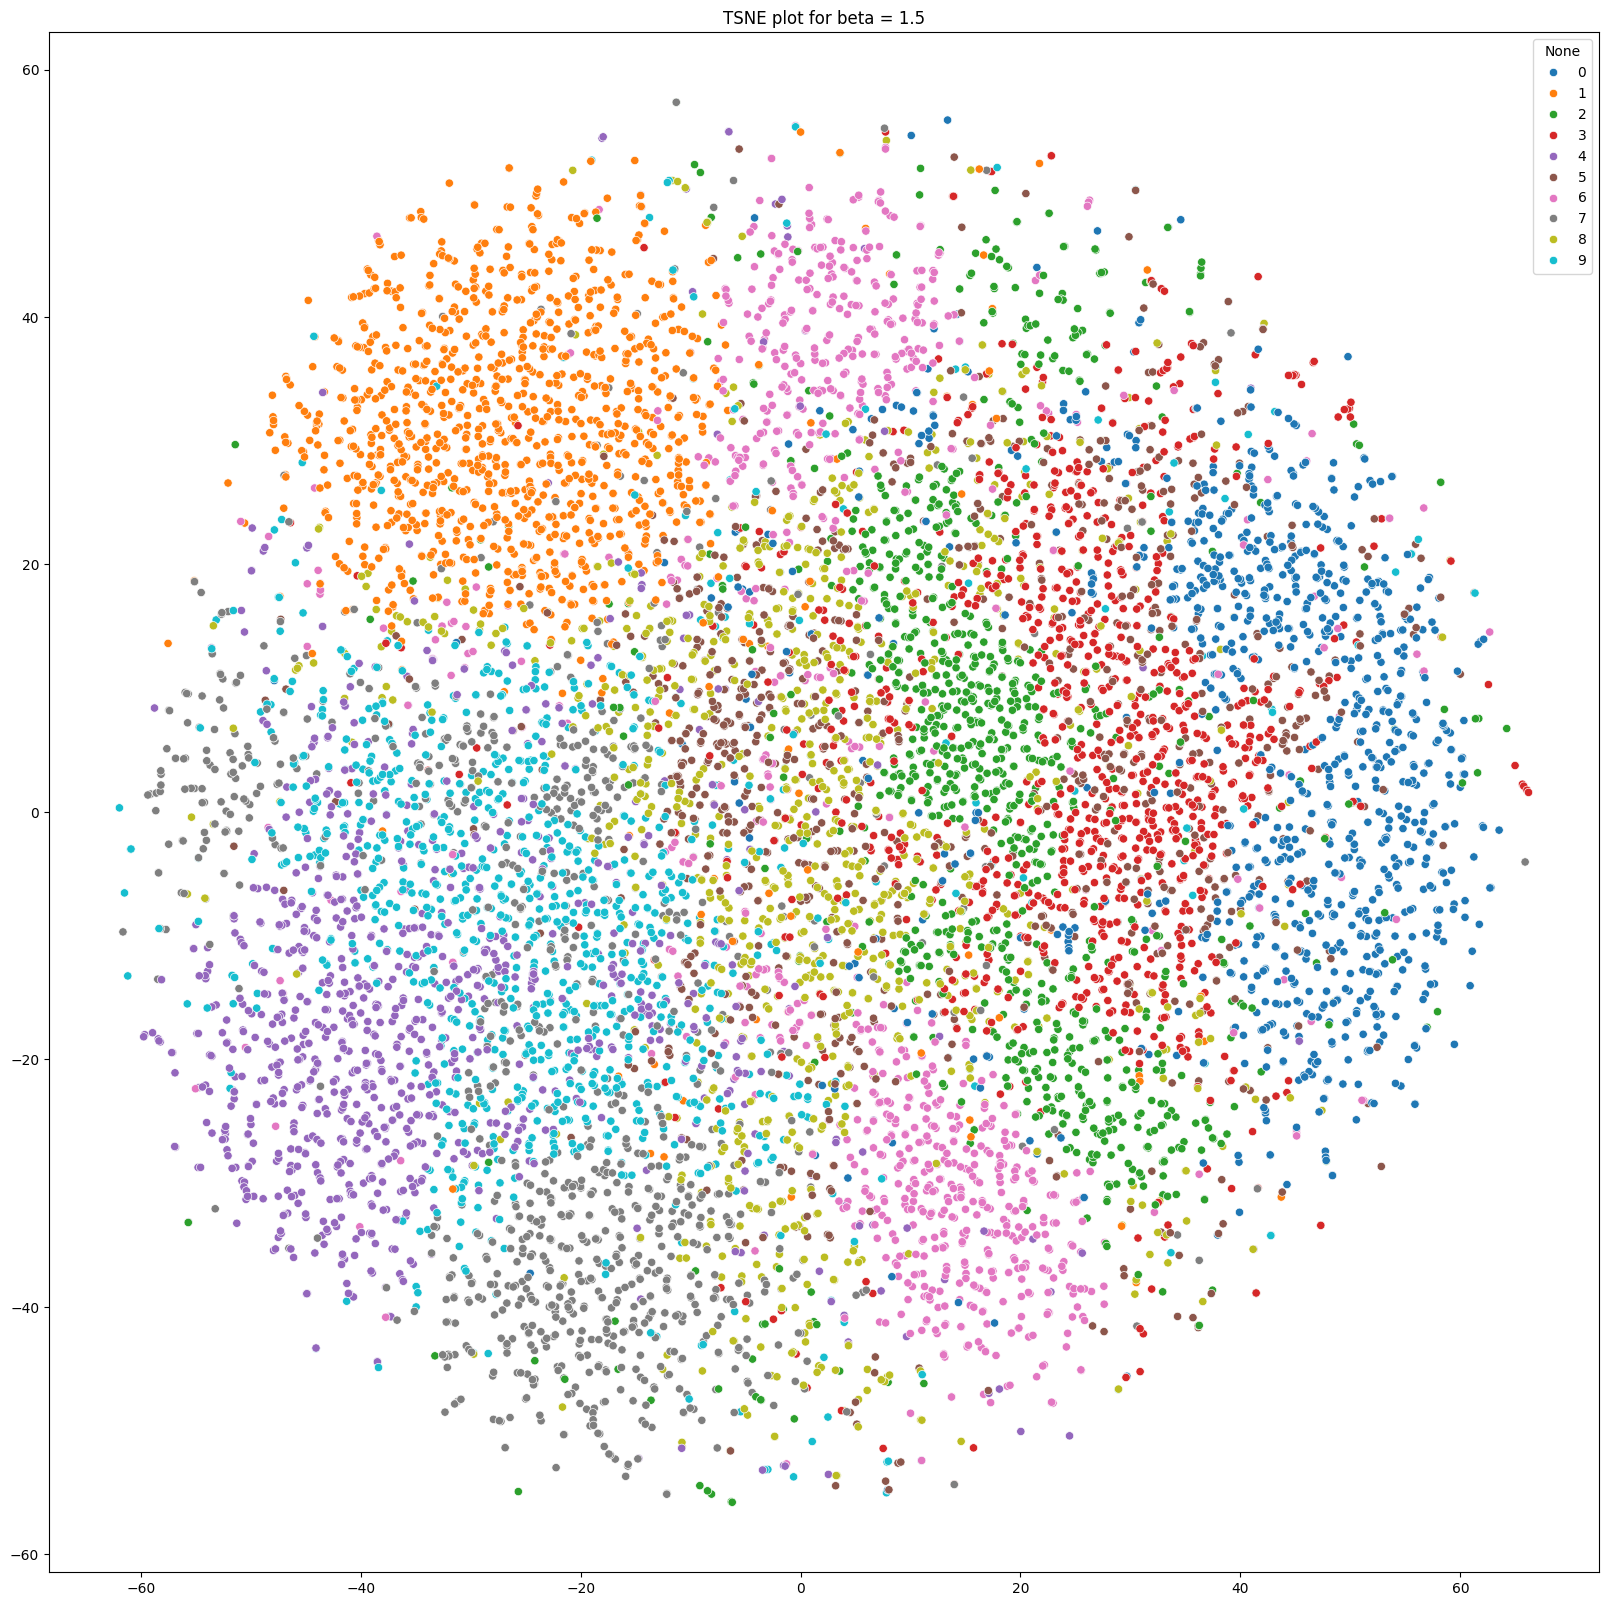

In [133]:
# Custom Visualizations
x, y = z_embedded[:, 0], z_embedded[:, 1]

targets = loader_test.dataset.targets

plt.figure(figsize=(20, 20))
sns.scatterplot(
    x=x, y=y, hue=targets, palette=sns.color_palette("tab10", 10), legend="full", 
)
plt.title("TSNE plot for beta = 1.5")


##### TSNE plot for beta = 0.5
<img src="VAE%20figs/tsne_beta0point5.png" alt="beta=1" width="800"/>

##### TSNE plot for beta = 1
<img src="VAE%20figs/tsne_beta1.png" alt="beta=1" width="800"/>

##### TSNE plot for beta = 2
<img src="VAE%20figs/tsne_beta2.png"  width="800"/>

##### TSNE plot for beta = 5
<img src="VAE%20figs/tsne_beta5.png"  width="800"/>



### Discussion
What do you observe? Discuss the structure of the visualized representations. 
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

Note - If you created multiple plots and want to include them in your discussion, the best option is to upload them to (e.g.) google drive and then embed them via a **public** share link. If you reference local files, please include these in your submission zip, and use relative pathing if you are embedding them (with the notebook in the base directory)

**YOUR ANSWER**

As the $\beta$ term is increased, you can see there becomes less separation between the digit classes. When $\beta$ = 0.5, you can clearly see the class clusters, with relatively few outliers and the boundaries are visible too, whereas when $\beta$ = 5, the points in each class are very spread out with no clear separation of classes. As mentioned before, $\beta$ allows you to control the emphasis given to the KL term in the loss, where increasing it encourages the model to minimise the difference between the posterior and Gaussian prior and this effect is most visible in the TSNE plot for $\beta$ = 5, where the points become more focussed on the center of the plot and diffuse out in a more uniform manner.
The classes (digits) that are close together for the lower $\beta$ values tend to have similar properties, for example, there is overlap with 4 and 9 even in the $\beta$ = 0.5 plot. I found that a $\beta$ of 1.5 gave a good balance between reconstruction and generation performance, and this is reflected in the TSNE plot, where there is still some separation of classes in clusters, but there are outliers and somewhat blurry boundaries which will aid in generation.

As long as TSNE is used sensibly, it can be reliable. For example, you cannot draw any conclusions from the relative size of clusters. I used 1000 iterations to try and ensure convergence of the algorithm; I tried values above this but 1000 seemed to be enough. However, the perplexity value can cause some issues. A range of 5-50 is recommended for perplexity; I used 50 as I found it gave me reasonable looking plots for all $\beta$ values. However, when experimenting with different perplexities for my final $\beta$ of 1.5, a value of 30 gave a more dispersed plot than 50 or 10, so caution must be exercised in this respect. As long as the perplexity is smaller than the number of points, it is generally fine; with the 30 vs 50 and 10 plots, there was still clear enough divisions between classes. It is also worth pointing out that reruns of the algorithm will result in different looking plots but given you are not looking at things like topology, you can draw the same general conclusions from them. 


## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

_hint: Locate the positions in latent space of 2 data points (maybe a one and an eight). Then sample multiple latent space vectors along the line which joins the 2 points and pass them through the decoder._


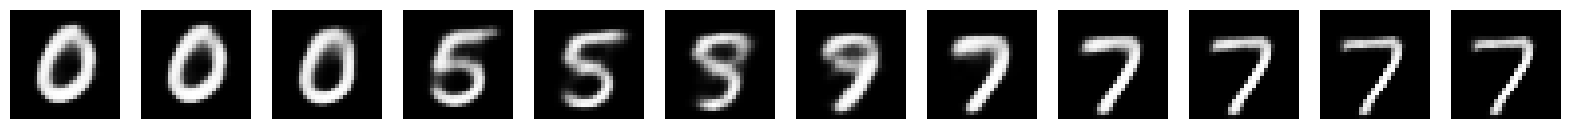

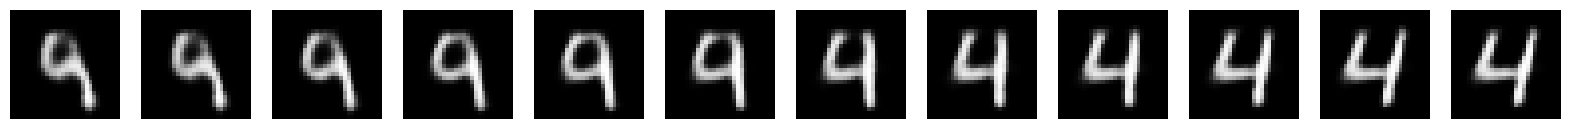

In [138]:
# CODE FOR PART 1.3b IN THIS CELL


def interpolation(target1, target2):
    def extract_data_points(target1, target2):
        for data, targets in loader_test:
            idx1 = (targets == target1).nonzero(as_tuple=True)[0]
            idx2 = (targets == target2).nonzero(as_tuple=True)[0]
    
            if len(idx1) > 0 and len(idx2) > 0:
                data_point1 = data[idx1[0]].view(1, 1, 28, 28)
                data_point2 = data[idx2[0]].view(1, 1, 28, 28)
                
                return data_point1, data_point2
        return None, None

    data_point1, data_point2 = extract_data_points(target1, target2)

    z1_mu, z1_var = model.encode(data_point1.to(device))
    z2_mu, z2_var = model.encode(data_point2.to(device))

    z1 = model.reparametrize(z1_mu, z1_var)
    z2 = model.reparametrize(z2_mu, z2_var)

    # z1 = z1.cpu().detach().numpy()
    # z2 = z2.cpu().detach().numpy()

    steps = np.linspace(0, 1, 10)
    diff = z2 - z1
    interpolated = [z1 + step * diff for step in steps]
    interpolated.append(z2)
    interpolated.insert(0, z1)

    decoded_points = torch.stack(
        [model.decode(vector.unsqueeze(0)) for vector in interpolated]
    )
    return decoded_points


decoded_points = interpolation(0, 7)

fig, axes = plt.subplots(1, len(decoded_points), figsize=(20, 2))
for i, img in enumerate(decoded_points):
    ax = axes[i]
    ax.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()

decoded_points = interpolation(9, 4)

fig, axes = plt.subplots(1, len(decoded_points), figsize=(20, 2))
for i, img in enumerate(decoded_points):
    ax = axes[i]
    ax.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()

### Discussion
What did you observe in the interpolation? Is this what you expected?



**YOUR ANSWER**

I have plotted the interpolation for two pairs of numbers, 0 & 7, and 4 & 9. 0 and 7 are on opposite ends of the TSNE plot and have a large seperation between their respective points on the plot (for the most part, as there are outliers). When transitioning, the 0 morphs into a 5, then nearly a 9, before becoming 7. This aligns with the separation of the classes seen in the TSNE plot. On the contrary, it is a smooth transition when moving from a 9 to a 4 and this is also expected as these two classes are very close on the TSNE plot, in fact there is a large amount of overlap meaning their latent spaces are close (and probably share commonalities).

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to load and run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

## Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. 

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.autograd as autograd
from torch.autograd import Variable

#mean = torch.Tensor([0.4914, 0.4822, 0.4465])
#std = torch.Tensor([0.247, 0.243, 0.261])
#normalise to [-1,1]
mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())


def denorm(x, channels=None, w=None, h=None, resize=False):
    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print("Number of channels, width and height must be provided for resize.")
        x = x.view(x.size(0), channels, w, h)
    return x


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


if not os.path.exists(content_path / "CW_GAN"):
    os.makedirs(content_path / "CW_GAN")

GPU = True  # Choose whether to use GPU
if GPU:
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
else:
    device = torch.device("cpu")
print(f"Using {device}")

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using mps


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small kernels, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [4]:
batch_size = 128  # change that

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
])

# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(
    data_path, train=True, download=True, transform=transform
)
cifar10_test = datasets.CIFAR10(
    data_path, train=False, download=True, transform=transform
)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

# check range of pixel values
dataiter = iter(loader_train)
images, labels = next(dataiter)
print(images.min(), images.max())

Files already downloaded and verified
Files already downloaded and verified
tensor(-1.) tensor(1.)


We'll visualize a subset of the test set: 

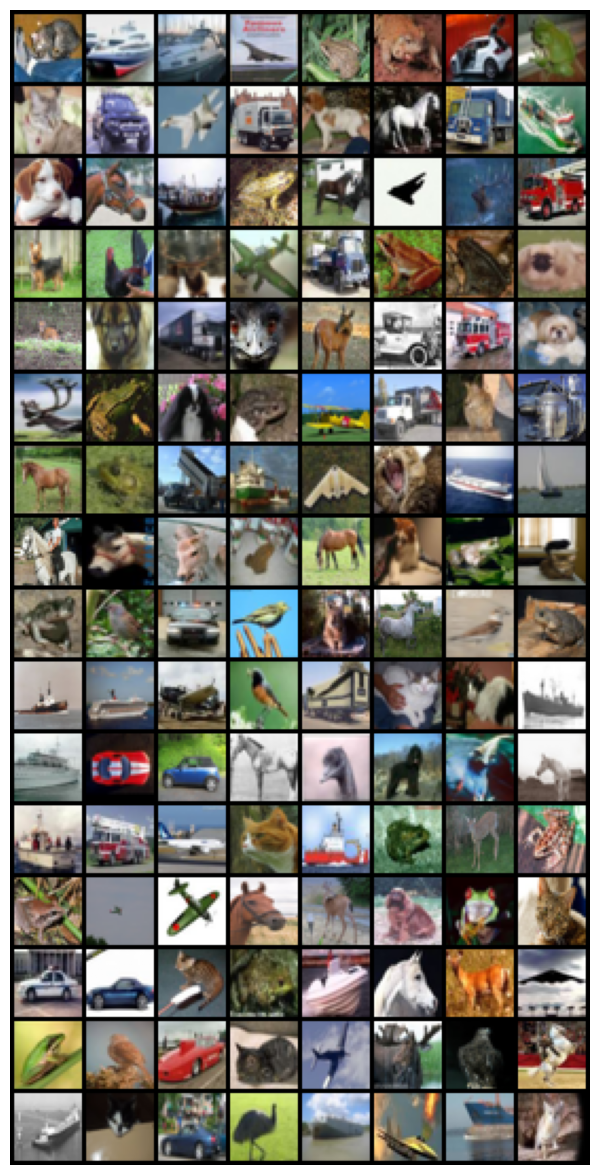

In [5]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(
    denorm(samples),
    nrow=8,
    padding=2,
    normalize=False,
    value_range=None,
    scale_each=False,
    pad_value=0,
)
plt.figure(figsize=(15, 15))
plt.axis("off")
show(samples)

In [6]:
classes = np.array(loader_train.dataset.targets)

print("classes: ", loader_train.dataset.classes)
print("number of images per class: ", np.bincount(classes))

print("image shape: ", loader_train.dataset.data[0].shape)

classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
number of images per class:  [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
image shape:  (32, 32, 3)


#### Model Definition
Define hyperparameters and the model

In [5]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 100

latent_vector_size = 100

learning_rate_disc = 2e-4
learning_rate_gen = 2e-4

# Other hyperparams
gen_feat_maps = 160
disc_feat_maps = 110
img_channels = 3
leakyrelu_slope = 0.2
dp_rate = 0.3
noise_std = 0.1
#noise_decay = noise_std / (num_epochs*2) # linear decay over training
noise_decay = 0
print(noise_decay)

0


In [21]:
# *CODE FOR PART 2.1 IN THIS CELL*


"""
from DCGAN paper:

Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
• Use batchnorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
"""


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from latent space to image of size 3x32x32 - transposed convolutions

        self.latent_vector_size = latent_vector_size
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.latent_vector_size,
                out_channels=gen_feat_maps * 8,
                kernel_size=4,
                stride=1,
                padding=0,
            ),  # 4x4
            nn.BatchNorm2d(gen_feat_maps * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 8,
                out_channels=gen_feat_maps * 4,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 8x8
            nn.BatchNorm2d(gen_feat_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 4,
                out_channels=gen_feat_maps * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 16x16
            nn.BatchNorm2d(gen_feat_maps * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 2,
                out_channels=img_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 32x32
            nn.Tanh(),  # no batchnorm here as per DCGAN paper
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from latent space to image
        out = self.generator(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Add_Noise(nn.Module):
    def __init__(self, std, decay):
        super(Add_Noise, self).__init__()
        self.std = std
        self.decay = decay

    def forward(self, x):
        if self.training:
            noise = torch.empty_like(x).normal_(mean=0, std=self.std)
            x = x + noise
            return x
        else:
            return x
        
    def decay_std(self):
        self.std = max(self.std - self.decay, 0)
    
    def get_noise_std(self):
        return self.std

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from image of size 3x32x32 to binary classification

        self.discriminator = nn.Sequential(
            Add_Noise(noise_std, noise_decay),
            nn.Conv2d(
                in_channels=img_channels,
                out_channels=disc_feat_maps * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 16x16
            # nn.BatchNorm2d(disc_feat_maps), # no batchnorm in first layer as per DCGAN paper
            nn.LeakyReLU(leakyrelu_slope, True),

            nn.Dropout(dp_rate),

            Add_Noise(noise_std, noise_decay),
            nn.Conv2d(
                in_channels=disc_feat_maps * 2,
                out_channels=disc_feat_maps * 4,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 8x8
            nn.BatchNorm2d(disc_feat_maps * 4),
            nn.LeakyReLU(leakyrelu_slope, True),

            nn.Dropout(dp_rate),

            Add_Noise(noise_std, noise_decay),
            nn.Conv2d(
                in_channels=disc_feat_maps * 4,
                out_channels=disc_feat_maps * 6,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # 4x4
            nn.BatchNorm2d(disc_feat_maps * 6),
            nn.LeakyReLU(leakyrelu_slope, True),
            
            nn.Dropout(dp_rate),
            
            Add_Noise(noise_std, noise_decay),
            nn.Conv2d(
                in_channels=disc_feat_maps * 6,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
            ),  # 1x1
            nn.Sigmoid(),  # binary classification
        )

        ######
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from image to binary classification

        out = self.discriminator(x).view(-1, 1)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        return out

In [80]:
# wgan architecture

"""
from DCGAN paper:

Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
• Use batchnorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
"""


"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from latent space to image of size 3x32x32 - transposed convolutions

        self.latent_vector_size = latent_vector_size
        self.generator = nn.Sequential(  #padding in convtranspose2d takes away from the output size by 2 x padding
            nn.ConvTranspose2d(
                in_channels=self.latent_vector_size,
                out_channels=gen_feat_maps * 10,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),  # 4x4, 512 channels
            nn.BatchNorm2d(gen_feat_maps * 10),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 10,
                out_channels=gen_feat_maps * 5,
                kernel_size=4,
                stride=2,
                padding=0,
                output_padding=1,
                bias=False,
            ),  # 11x11, 512 channels
            nn.BatchNorm2d(gen_feat_maps * 5),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 5,
                out_channels=gen_feat_maps * 2,
                kernel_size=4,
                stride=2,
                padding=0,
                bias=False,
            ),  # 24x24, 256 channels
            nn.BatchNorm2d(gen_feat_maps * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 2,
                out_channels=gen_feat_maps ,
                kernel_size=5,
                stride=1,
                padding=0,
                bias=False,
            ),  # 28x28, 128 channels
            nn.BatchNorm2d(gen_feat_maps),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps,
                out_channels=img_channels,
                kernel_size=5,
                stride=1,
                padding=0,
                bias=False,
            ),  # 32x32, 3 channels
            nn.Tanh(),  # no batchnorm here as per DCGAN paper
            nn.Flatten(),
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from latent space to image
        out = self.generator(z)
        # out = out.view(-1, 3072) #3x32x32 = 3072
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out
"""

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from latent space to image of size 3x32x32 - transposed convolutions

        self.latent_vector_size = latent_vector_size
        self.generator = nn.Sequential(  #padding in convtranspose2d takes away from the output size by 2 x padding
            nn.ConvTranspose2d(
                in_channels= latent_vector_size,
                out_channels=gen_feat_maps * 5,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),  # 4x4 
            nn.BatchNorm2d(gen_feat_maps * 5),
            nn.ReLU(True),
            nn.Dropout2d(dp_rate),
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 5,
                out_channels=gen_feat_maps * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # 8x8
            nn.BatchNorm2d(gen_feat_maps * 2),
            nn.ReLU(True),
            nn.Dropout2d(dp_rate),
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps * 2,
                out_channels=gen_feat_maps ,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # 16x16
            nn.BatchNorm2d(gen_feat_maps),
            nn.ReLU(True),
            nn.Dropout2d(dp_rate),
            nn.ConvTranspose2d(
                in_channels=gen_feat_maps,
                out_channels=img_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # 32x32, 3 channels
            nn.Tanh(),  # no batchnorm here as per DCGAN paper
            nn.Flatten(),
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from latent space to image
        out = self.generator(z)
        # out = out.view(-1, 3072) #3x32x32 = 3072
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from image of size 3x32x32 to binary classification

        # wangp discriminator
        self.discriminator = nn.Sequential(
            nn.Conv2d(
                in_channels=img_channels,
                out_channels=disc_feat_maps,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=False,
            ),  # 16x16, 64 channels
            nn.LeakyReLU(leakyrelu_slope),
            nn.Conv2d(
                in_channels=disc_feat_maps,
                out_channels=disc_feat_maps * 2,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=False,
            ),  # 8x8, 128 channels
            nn.LeakyReLU(leakyrelu_slope),
            nn.Conv2d(
                in_channels=disc_feat_maps * 2,
                out_channels=disc_feat_maps * 4,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=False,
            ),  # 4x4, 256 channels
            nn.LeakyReLU(leakyrelu_slope),
        )

        self.linear = nn.Linear(4 * disc_feat_maps * 4 * 4, 1)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # go from image to binary classification
        out = x.view(-1, 3, 32, 32)
        out = self.discriminator(out)
        out = out.view(-1, 4 * 4 * 4 * disc_feat_maps)
        out = self.linear(out)
        out = out.view(-1)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        return out

In [7]:
#!pip install torchsummary
from torchsummary import summary

summarygen = Generator()
summary(summarygen, (latent_vector_size, 1, 1))
summarydisc = Discriminator()
summary(summarydisc, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1280, 4, 4]       2,049,280
       BatchNorm2d-2           [-1, 1280, 4, 4]           2,560
              ReLU-3           [-1, 1280, 4, 4]               0
   ConvTranspose2d-4            [-1, 640, 8, 8]      13,107,840
       BatchNorm2d-5            [-1, 640, 8, 8]           1,280
              ReLU-6            [-1, 640, 8, 8]               0
   ConvTranspose2d-7          [-1, 320, 16, 16]       3,277,120
       BatchNorm2d-8          [-1, 320, 16, 16]             640
              ReLU-9          [-1, 320, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]          15,363
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 18,454,083
Trainable params: 18,454,083
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    # elif classname.find('LayerNorm') != -1:
    #   m.weight.data.normal_(1.0, 0.02)
    #  m.bias.data.fill_(0)

In [22]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print("\n")

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print("\n")

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 18454083
Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 1280, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1280, 640, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(640, 320, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(320, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 6219841
Discriminator(
  (discriminator): Sequential(
    (0): Add_Noise()
    (1): Conv2d(3, 220, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [10]:
# You can modify the arguments of this function if needed
gan_criterion = nn.BCELoss(reduction='mean') #reduction='mean'

def loss_function(out, true):
    loss = gan_criterion(out, true)
    return loss


<h3>Choose and initialize optimizers</h3>

In [26]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
beta2 = 0.9
optimizerD = torch.optim.Adam(
    model_D.parameters(),
    lr=learning_rate_disc,
    betas=(beta1, beta2),
)
optimizerG = torch.optim.Adam(
    model_G.parameters(),
    lr=learning_rate_gen,
    betas=(beta1, beta2),
)

#Different schedulers I tried are commented out below

"""

num_batches = len(loader_train)
max_steps = num_epochs * num_batches

scheduler_lambda = lambda epoch: max(
    1e-4, (max_steps - epoch * num_batches) / max_steps
)

decay_epochs = num_epochs
scheduler_lambda_alt = lambda epoch: max(
    0.00001 / learning_rate_disc, (1 - epoch / decay_epochs)
)

target_lr = 1.5e-4
disc_lambda = lambda epoch: np.exp(np.log(target_lr/learning_rate_disc)/(num_epochs/2))**epoch # start lr to target over num_epochs

#lr_schedulerD = torch.optim.lr_scheduler.LambdaLR(
#    optimizerD, lr_lambda=disc_lambda, verbose=False
#)

#lr_schedulerG = torch.optim.lr_scheduler.LambdaLR(
#    optimizerG, lr_lambda=scheduler_lambda_alt, verbose=False
#)

#gamma = (target_lr / learning_rate_disc) ** (1 / num_epochs)
#lr_schedulerD = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

"""

lr_schedulerD = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerD, 'min', patience=5, verbose=False, factor=0.9)
lr_schedulerG = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerG, 'min', patience=15, verbose=False, factor=0.9)




print(optimizerD.param_groups[0]["lr"])
print(optimizerG.param_groups[0]["lr"])
print(lr_schedulerD.patience)
print(lr_schedulerG.patience)

0.0002
0.0002
5
15


<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [12]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Additional input variables should be defined here

#### Training Loop

Complete the training loop below. We've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [27]:
# non wangp training

train_losses_G = []
train_losses_D = []
K = 1


print(
    "using device", next(model_D.parameters()).device, next(model_G.parameters()).device
)
print("total epochs:", num_epochs)
print(
    "learning rate disc =",
    optimizerD.param_groups[0]["lr"],
    "learning rate gen =",
    optimizerG.param_groups[0]["lr"],
)
print("latent vector size =", latent_vector_size)
print("batch size =", batch_size)
print("noise decay =", noise_decay)
print(
    "params in D =",
    sum(p.numel() for p in model_D.parameters() if p.requires_grad),
    "params in G =",
    sum(p.numel() for p in model_G.parameters() if p.requires_grad),
)

for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        train_loss_D = 0
        train_loss_G = 0

        for i, data in enumerate(tepoch):
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            model_D.zero_grad()

            # train with real

            real_cpu = data[0].to(device)
            actual_batch_size = real_cpu.size(0)  # not always exactly batch_size

            # label smoothing
            real_labels = torch.full((actual_batch_size, 1), 0.9).to(device)
            fake_labels = torch.zeros(actual_batch_size, 1).to(device)


            disc_out_real = model_D(real_cpu)
            disc_real_loss = loss_function(disc_out_real, real_labels)
            disc_real_loss.backward()  # backprop loss for real images
            D_x = disc_out_real.mean().item()  # output of disc for real images

            # train with fake

            noise = torch.randn(actual_batch_size, latent_vector_size, 1, 1).to(device)
            gen_out = model_G(noise)  # generate fake images

            disc_out_fake = model_D(gen_out.detach())

            disc_fake_loss = loss_function(disc_out_fake, fake_labels)
            disc_fake_loss.backward()  # backprop loss for fake images

            D_G_z1 = disc_out_fake.mean().item()
            errD = disc_real_loss + disc_fake_loss
            train_loss_D += errD.item()

            optimizerD.step() # update discriminator

            # (2) Update G network: maximize log(D(G(z)))

            model_G.zero_grad()

            labels = torch.full((actual_batch_size, 1), 0.9).to(device) # label smoothing

            noise = torch.randn(actual_batch_size, latent_vector_size, 1, 1).to(device)  
            gen_out = model_G(noise)  # generate new fake images
            disc_out = model_D(gen_out)

            gen_loss = loss_function(disc_out, labels)

            gen_loss.backward() # backprop loss for generator
            D_G_z2 = disc_out.mean().item()
            errG = gen_loss
            train_loss_G += errG.item()

            optimizerG.step() # update generator

            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging

            noise_stds = [
                model_D.discriminator[0].std,
                model_D.discriminator[4].std,
                model_D.discriminator[9].std,
                model_D.discriminator[14].std,
            ]
            noise_std_str = "/".join(f"{std:.4f}" for std in noise_stds)

            if i % 10 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(
                    D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}",
                    D_x=D_x,
                    Loss_D=errD.item(),
                    Loss_G=errG.item(),
                    noise_stds=noise_std_str,
                    train_losses_D=train_loss_D / (i + 1),
                    train_losses_G=train_loss_G / (i + 1),
                    disc_lr=optimizerD.param_groups[0]["lr"],
                    gen_lr=optimizerG.param_groups[0]["lr"],
                )

    # lower lr if loss hasnt decreased for last n epochs (n set in lr_scheduler)
    if len(train_losses_G) > 1:
        lr_schedulerD.step(train_losses_G[-1])

    if len(train_losses_D) > 1:
        lr_schedulerG.step(train_losses_D[-1])

    # decay noise std - tried this but didn't work well so I commented it out - noise decay also set to 0 in hyperparams

    """
    #see if loss hasnt decreased for last 5 epochs
    if len(train_losses_D) > 5:
        last_disc_losses = train_losses_D[-5:]
        if all(last_disc_losses[-1] >= loss for loss in last_disc_losses[:-1]):
            model_D.discriminator[0].decay_std()
            model_D.discriminator[4].decay_std()
            model_D.discriminator[9].decay_std()
            model_D.discriminator[14].decay_std()

    #model_D.discriminator[0].decay_std()
    #model_D.discriminator[4].decay_std()
    #model_D.discriminator[9].decay_std()
    #model_D.discriminator[14].decay_std()
    """

    if epoch == 0:
        save_image(
            denorm(real_cpu.cpu()).float(), content_path / "CW_GAN/real_samples.png"
        )
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(
            denorm(fake.cpu()).float(),
            str(content_path / "CW_GAN/fake_samples_epoch_%03d.png") % epoch,
        )
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(
    torch.jit.trace(model_G, (fixed_noise)), content_path / "CW_GAN/GAN_G_model.pth"
)
torch.jit.save(
    torch.jit.trace(model_D, (fake)), content_path / "CW_GAN/GAN_D_model.pth"
)

using device mps:0 mps:0
total epochs: 100
learning rate disc = 0.0002 learning rate gen = 0.0002
latent vector size = 100
batch size = 128
noise decay = 0
params in D = 6219841 params in G = 18454083


Epoch 99: 100%|██████████| 391/391 [03:11<00:00,  2.04batch/s, D_G_z=0.437/0.394, D_x=0.501, Loss_D=1.32, Loss_G=0.944, disc_lr=5.65e-5, gen_lr=0.000118, noise_stds=0.1000/0.1000/0.1000/0.1000, train_losses_D=1.32, train_losses_G=0.897]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/jit/_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 128 / 128 (100.0%)
Greatest absolute difference: 0.5499271154403687 at index (9, 0) (up to 1e-05 allowed)
Greatest relative difference: 4.969325065612793 at index (9, 0) (up to 1e-05 allowed)
  _check_trace(


In [85]:
# Wasserstein GP GAN training - couldn't get it to work well but left here as evidence I tried (for a while)

"""
def grad_penalty(real_samples, fake_samples):

    alpha = torch.FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    interpolate = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True).to(device)
    disc_interpolate = model_D(interpolate)
    fakes = Variable(torch.FloatTensor(torch.ones(real_samples.shape[0], 1, requires_grad=False))).to(device)

    gradients = autograd.grad( outputs=disc_interpolate, inputs=interpolate, grad_outputs=fakes, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

"""


def grad_penalty(real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolated_samples = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolated_samples = Variable(interpolated_samples, requires_grad=True)

    # diff = fake_samples - real_samples
    # interpolates = real_samples + (alpha * diff)
    # interpolates = Variable(interpolates, requires_grad=True)
    disc_interpolated = model_D(interpolated_samples)

    grad = autograd.grad(
        outputs=disc_interpolated.to(device),
        inputs=interpolated_samples.to(device),
        grad_outputs=torch.ones_like(disc_interpolated).to(device),
        create_graph=True,
        retain_graph=True,
    )[0]

    grad = grad.view(real_samples.size(0), -1)
    grad_norm = grad.norm(2, dim=1)
    penalty = ((grad_norm - 1) ** 2).mean()
    # grad = grad.view(grad.size(0), -1)
    # slopes = torch.sqrt(torch.sum(grad ** 2, dim=1))
    # gradient_penalty = torch.mean((slopes - 1) ** 2)

    # print(ac_batch_size, alpha.device, interpolated_samples.device, disc_interpolated.device, grad.device, grad_norm.device, penalty.device)

    return penalty


def add_noise(x):
    noise = (torch.normal(mean=0, std=0.1, size=x.size())).to(device)
    return x + noise


n_critic = 5  # default value from WGAN-GP paper
lambda_gp = 10  # default value from WGAN-GP paper


train_losses_G = []
train_losses_D = []
K = 1
print(
    "using device", next(model_D.parameters()).device, next(model_G.parameters()).device
)
print("total epochs:", num_epochs)
print(
    "learning rate disc =",
    optimizerD.param_groups[0]["lr"],
    "learning rate gen =",
    optimizerG.param_groups[0]["lr"],
)
print("latent vector size =", latent_vector_size)
print("n_critic =", n_critic)
print("lambda_gp =", lambda_gp)
print("batch size =", batch_size)
print("params in D =", sum(p.numel() for p in model_D.parameters() if p.requires_grad), "params in G =", sum(p.numel() for p in model_G.parameters() if p.requires_grad))


# <- You may wish to add logging info here

for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    model_G.train()
    model_D.train()
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0

            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################

            ### discriminator
            optimizerD.zero_grad()

            real_cpu = Variable(data[0].to(device))
            actual_batch_size = real_cpu.size(0)
            noise = torch.randn(actual_batch_size, latent_vector_size, 1, 1).to(
                device
            )
            gen_out_fake = model_G(noise)

            disc_real_out = model_D(real_cpu)
            disc_fake_out = model_D(gen_out_fake.detach())

            gen_out_fake = gen_out_fake.view(-1, 3, 32, 32)
            real_cpu = add_noise(real_cpu)  # add noise to real images
            gen_out_fake = add_noise(gen_out_fake)  # add noise to fake images

            gradient_penalty = grad_penalty(real_cpu, gen_out_fake)
            disc_loss = (
                -torch.mean(disc_real_out)
                + torch.mean(disc_fake_out)
                + lambda_gp * gradient_penalty
            )

            # print(disc_loss.item(), gradient_penalty.item())

            disc_loss.backward()
            optimizerD.step()

            errD = disc_loss.item()
            D_x = disc_real_out.mean().item()
            D_G_z1 = disc_fake_out.mean().item()

            train_loss_D += disc_loss.item()

            ### generator

            if i % n_critic == 0:

                optimizerG.zero_grad()

                noise = torch.randn(actual_batch_size, latent_vector_size, 1, 1).to(device)
                fake = model_G(noise)

                disc_fake_out_2 = model_D(fake)
                gen_loss = -torch.mean(disc_fake_out_2)

                gen_loss.backward()
                optimizerG.step()

                errG = gen_loss.item()
                D_G_z2 = disc_fake_out_2.mean().item()

                train_loss_G += gen_loss.item()

            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging
 
            if i % 10 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(
                    D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}",
                    D_x=D_x,
                    Loss_D=errD,
                    Loss_G=errG,
                    Loss_diff=errD - errG,
                    gradient_penalty=gradient_penalty.item(),
                    lr_D=optimizerD.param_groups[0]["lr"],
                    lr_G=optimizerG.param_groups[0]["lr"],                   
                )

    # lr_schedulerD.step()
    # lr_schedulerG.step()
                
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
    
    model_G.eval()
    model_D.eval()
    if epoch == 0:
        save_image(
            denorm(real_cpu.cpu()).float(), content_path / "CW_GAN/real_samples.png"
        )
    with torch.no_grad():
        fake = model_G(fixed_noise)
        fake = fake.view(-1, 3, 32, 32)
        save_image(
            denorm(fake.cpu()).float(),
            str(content_path / "CW_GAN/fake_samples_epoch_%03d.png") % epoch,
        )
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(
    torch.jit.trace(model_G, (fixed_noise)), content_path / "CW_GAN/GAN_G_model.pth"
)
torch.jit.save(
    torch.jit.trace(model_D, (fake)), content_path / "CW_GAN/GAN_D_model.pth"
)

#lr to 0.0002
#increase disc params - num filters up from 128 to 180
#shuffle train data

using device mps:0 mps:0
total epochs: 30
learning rate disc = 0.0002 learning rate gen = 0.0002
latent vector size = 100
n_critic = 5
lambda_gp = 10
batch size = 64
params in D = 8125021 params in G = 14647296


Epoch 15:   9%|▉         | 70/782 [00:17<02:58,  3.98batch/s, D_G_z=42.547/46.179, D_x=69, Loss_D=-22.5, Loss_G=-46.2, gradient_penalty=0.398, lr_D=0.0002, lr_G=0.0002, train_losses_D=-.368, train_losses_G=-.77]   


KeyboardInterrupt: 

## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=18aWqRAnAVTRDY52y1yHSCdqSxUFRKOS9" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1ymO2-jGAvWeUR2kaj_LxQcGYF1RWNRnw" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=13SW62ekW32NMYtfcdm_dCJJ3ZMOZEZAJ" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

### Generator samples

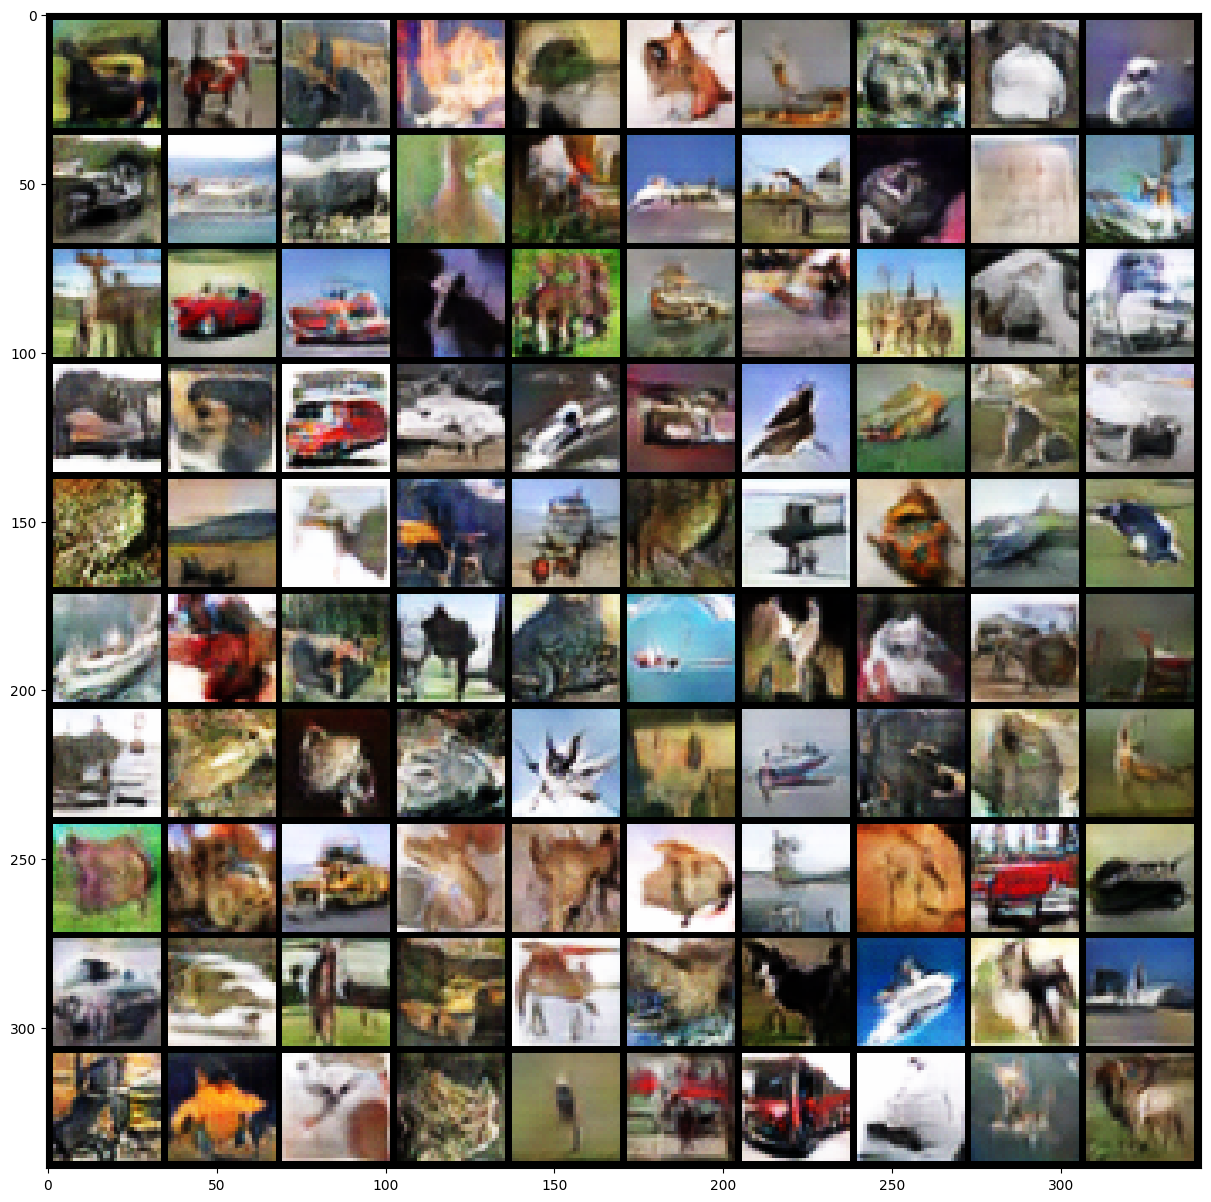

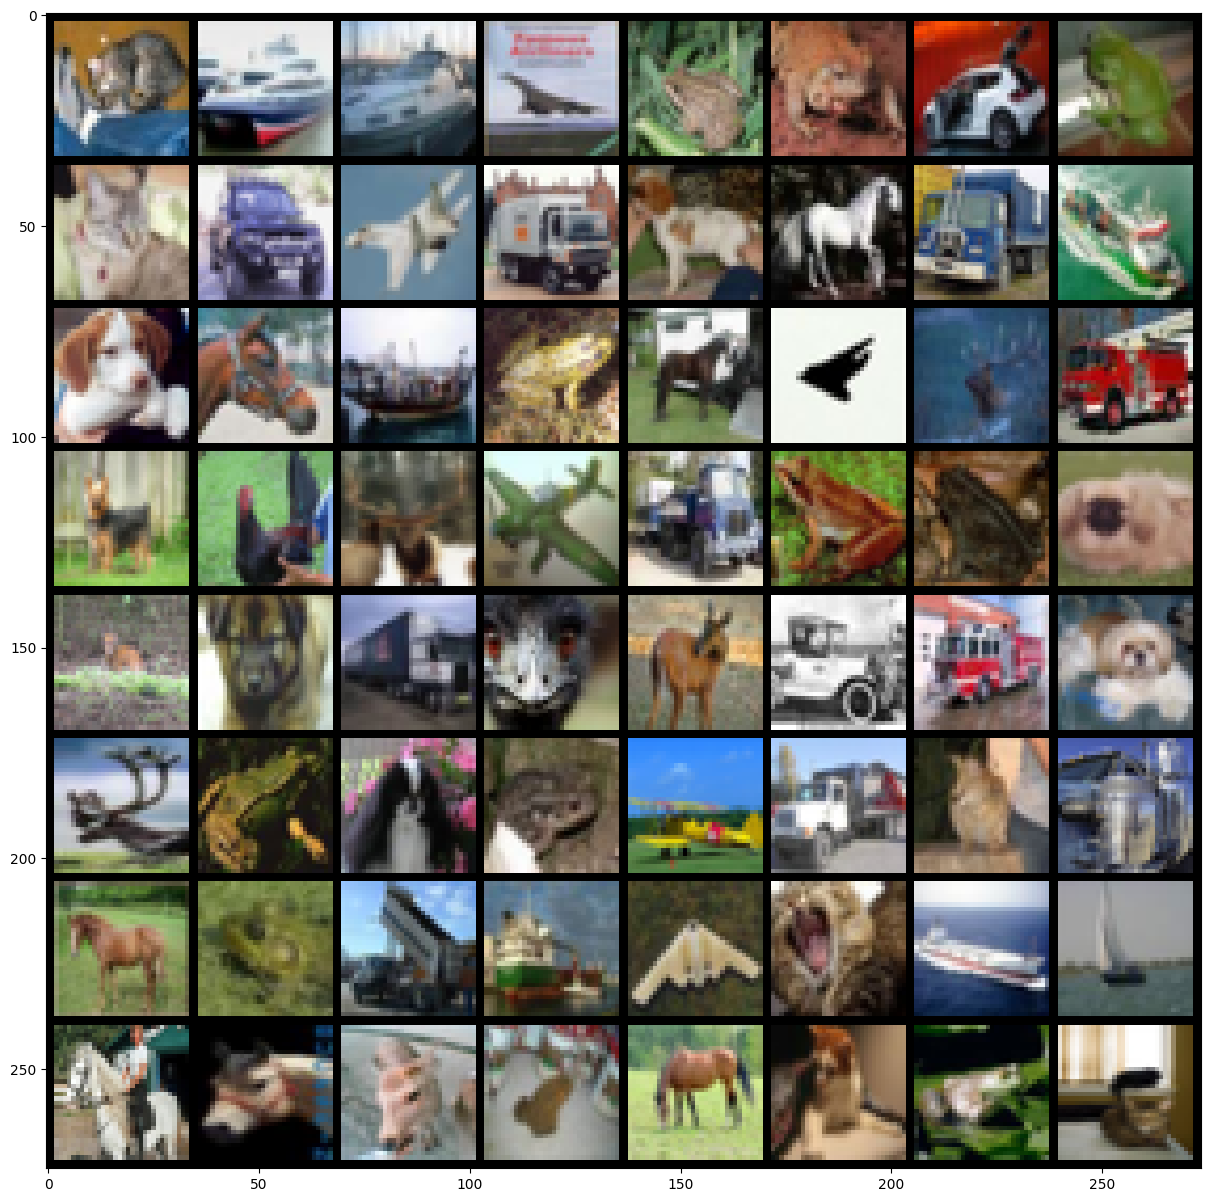

In [56]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(
        denorm(generated)[:100],
        nrow=10,
        padding=2,
        normalize=False,
        value_range=None,
        scale_each=False,
        pad_value=0,
    )
    plt.figure(figsize=(15, 15))
    save_image(generated, content_path / "CW_GAN/Teaching_final.png")
    show(generated)


it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(
    denorm(fixed_input),
    nrow=8,
    padding=2,
    normalize=False,
    value_range=None,
    scale_each=False,
    pad_value=0,
)
plt.figure(figsize=(15, 15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**

I started with the DCGAN architecture, with the number of parameters in the generator being more than in the discriminator. Four layers worked nicely to get the correct image up/downscaling. Some changes were made though, with the DCGAN paper suggesting switching ReLU for LeakyReLU in the discriminator with a slope of 0.2 and no batchnorm in the final layer of the generator and input layer of the discriminator to help with stability. It is generally recommended to use strided convolutions for downsampling as opposed to pooling and transposed convolutions for upsampling to let the network learn whats needed for this. I also had the learning rate for the discriminator and generator at 2e-4 and the beta values for the Adam optimizer at 0.5 and 0.9; these beta values stayed the same throughout this entire process as I did not feel a need to alter them since there were bigger issues to deal with. These hyperparameter choices were also set out in the DCGAN paper. The loss chosen is binary cross entropy (BCE) as you want the images from generator to be given a high probability of being real by the discriminator and using the same loss function for the generator and discriminator allows you to use the non-saturating loss to prevent the discriminator quickly becoming too powerful at the beginning of training. However, the initial results yielded mediocre results, with greyed out noisy images that did not resemble anything meaningful. Following some trial and error style hyperparameter tuning, I found that I was also sometimes dealing with mode collapse, so decided to try and remedy this by changing the loss function to WGAN-GP since this would in theory help this and potentially aid in improving performance.

To use this new loss function, I needed to create a function to calculate the gradient penalty using autograd. I made the necessary recommended tweaks from the paper such as removing critic batchnorm and used the default hyperparameters from there, but after running the training, I found that the performance was even worse. It was difficult to diagnose what was going wrong as the loss values are less meaningful with WGAN-GP due to its use of the 'Earth-Mover' distance metric where it tries to maximise the distance. 
I scoured the internet for as many GAN training tricks as I could find, here is what I tried:
* Adjusting the training time between the generator and discriminator so one did not become too strong compared to the other and prevent the other learning - this was something I was constantly doing throughout the experimenting process and helped performance when the balance was corrected. I was usually training the discriminator more than the generator, but I found the model performance with a for loop (repeating training in the same batch) resulted in worse performance than skipping training for the generator for a number of batches.
* Removing the sigmoid layer at the end of the discriminator and using the BCEWithLogits loss - I thought this might help with the discriminator's loss fluctuating around the same value but it did not.
* A linear layer at the end of the discriminator to see if it would learn some new useful information - this did not help either.
* Putting layernorm in as a replacement for batchnorm - this did help since it introduces regularization in the discriminator so it does not become too confident and hinder the generator's training. Batchnorm introduces correlations between examples  which breaks WGAN-GP, but layernorm does not.
* Introducing dropout in the discriminator - this also helped with regularization.
* Inserting noise into the discriminator -  I tried noise just into the input, and noise in every layer apart from the last. The latter another regularization technique suggested by Arjovsky et. al., Huszar, 2016. 
* Shuffling the training data - I tried this as the generator was being training every n batches, and I wanted to make sure it was seeing all the available data. However, this did not make a difference in the quality of images produced.
* Learning rate schedulers to balance the discriminator and generator learning so one does not get ahead of the other - this did help slightly, but did not make a significant difference.

It is important to note that I made these additions one-by-one to properly assess their impacts, and eventually made most of them implemented in an attempt to get good performance out of the WGAN-GP setup. Stability was the main issue with this model where the losses would not behave nicely and images were often noisy and generally poor quality. I also tried different architecture setups; I saw multiple people on StackOverflow say that a comparatively sized generator and discriminator would help, so I tried this along with adding/removing layers but I still was not able to get good performance out of the network, so I reverted back to the old setup.

To remedy the issues I was experiencing before, I implemented many of the tricks I had tried for WGAN-GP. Since the loss for the discriminator was going to 0 and it was predicting 1 for real images, I needed to hinder its learning; this is why I was not training it for more often than the generator. I increased the complexity of the generator and tried a lower discriminator learning rate of 1.5e-4 compared to 2e-4 for the generator, but this alone did not help solve the vanishing gradient. So I put in dropout and introduced noise to every layer of the discriminator (apart from the final layer). This allieviated the vanishing gradient issue, but the images I was getting where still tinted grey and noisy. To solve the grey image issue, I altered the standard deviation for the normalize function used in the DataLoader so that the pixel range is from -1 to 1 (the same as the tanh function used at the end of the generator). To help the performance issues, I tried a trick that frequently came up that I could not try with the WGAN-GP version; label smoothing. I implemented one-sided label smoothing and this greatly helped the performance as expected, since in the original paper it is suggested that label smoothing increases the discrimator's entropy in its output, making it less confident in its predictions. This helped the situation where the discriminator was becoming too powerful compared to the generator beyond around epoch 15. I also tried two-sided label smoothing (increase the value for fake images from 0 to 0.2) and also random label smoothing (sample the labels from a uniform distribution from 0.8 to 1) but neither of these helped so I went back to one-sided smoothing.  
I still had issues with a lack of convergence of the discriminator and generator losses; the generator loss would begin to increase around epoch 30 and keep climbing way beyond 1, and the discriminator loss would continue to decline. So i tried different learning rates, tried noise decay for the discriminator and multiple learning rate schedulers for the discriminator to try and stop it overpowering the generator over time. None of these solved this issue - although I did begin to see a pattern where the lowering the noise decay has far more of an impact on the discriminator becoming too powerful so after a few iterations I left this on. I suspected that perhaps the discriminator had too much capacity, so I lowered its number of feature maps and increased the generator's feature maps. I tried changing the number of layers in the WGAN-GP setup and it did not help, which does not necessarily mean it would not helped here but it was easier to change the number of feature maps so that is the architecture change strategy I used. This helped to delay the diveregence of loss, but not eliminate it. Data augmentation of random flipping, scaling and rotation of images make no difference in the performance of the network so this was removed.

I finally decided to try the ReduceLROnPlateau learning rate scheduler, where I would decrease the discriminator's learning rate if there was no improvement in the generator's loss after a set number of epochs. This worked very well; the discriminator loss remained fairly constant, and the generator's continued to drop. After this success, I tried doing something similar for the generator's scheduler, where it would lower it's learning rate after no improvement in the discriminator's loss value as I still wanted both losses to fall over time. I made the patience for the generator's scheduler longer as it was the generator's loss I was having issues with. This solved the convergence issues and resulted in the best images from the model. I tried increasing the capacity of the discriminator and reducing the capacity of the generator as the generator's loss decreased quicker, which resulted in a greater decrease in loss for the discriminator and a slight increase in loss past epoch 60 for the generator, but the resulting images were very similar so I stuck with the previous configuration after deciding that the time I could spend fine-tuning the model outweighes the benefits.



## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

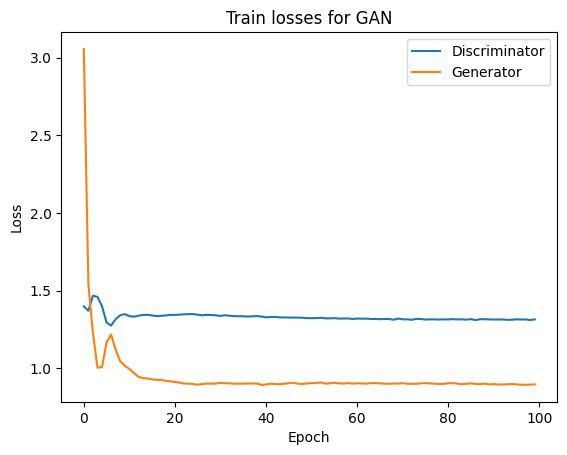

In [55]:
# ANSWER FOR PART 2.2 IN THIS CELL*

plt.figure()
plt.plot(train_losses_D)
plt.plot(train_losses_G)
plt.legend(("Discriminator", "Generator"))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train losses for GAN")
plt.show()

### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

The loss curves are stable, with both slightly decreasing beyond epoch 40 which is expected given the learning rate scheduler I put in place to prevent the generator diverging. There are small fluctuations too which is also expected given the discriminator and generator are competing against each other; where one improves the other should become worse. 


One thing I noticed in the output logs is that the discriminator's guesses for real images hovered slightly above 0.5 for a lot of the training, which could indicate that the generator a good match for the discriminator for large parts of the training, since a value of 0.45 means that the discriminator was just guessing (the label smoothing means that 0.9 is the true value for real images). 



To illustrate some of the issues I was having with WGAN-GP, below is one of the loss plots from towards the end of my attempts with this loss. The Generator loss was increasing, but I could not get the discriminator loss to stop fluctuating around the same values. Also, it is hard to see on the graph but the gradient penalty was well behaved; it stayed around 1 as it should have done. I thought that changing the lambda value to alter the magnitude of the gradient penalty applied to the discriminator loss would remedy this since it directly affects the loss value, but it did not make much of a difference when i moved it up or down.

I have also included an example of the type of images I was getting; over saturated and not representative of any of the image classes.

![WGAN-GP losses](wgangp%20loss%20curves.png)

![WAN-GP Example Images](wangp%20example%20images.png)

## Part 2.3: Understanding Mode Collapse (5 points) 
**Your task:**
 
Describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN. 

Based on the images created by your generator using the `fixed_noise` vector during training, did you notice any mode collapse? what this behaviour may be attributed to, and what did you try to eliminate / reduce it?

![Mode Collapse](mode%20collapse.png)

### Discussion


**YOUR ANSWER**

Mode collapse occurs when the generator creates a limited set of images which it has learned can fool the generator; it becomes stuck in a particular mode or modes where it no longer generates diverse outputs that cover the entire range of the data (looking at the entire training data distribution). It is most easily spotted by looking at the generated images and seeing repeated features. This can be seen in the above image, where many of the images produced look similar, in particular the ones with the vertical lines with a pale background.

Mode collapse can be caused by the discriminator getting stuck in a local minimum, which it is unable to escape from and subsequent iterations of the generator optimizes for a particular discriminator and the discriminator cannot get out of this. The discriminator becoming too powerful is another cause, as this can make it difficult for the generator to produce good outputs. In my case, it was this and possibly gradient vanishing too, where gradients used to update the generator become too small, causing mode collapse.

As mentioned in section 2.1, I tried switching to the WGAN-GP loss function to eliminate mode collapse since it should in theory give a more stable training signal for smoother learning and reduced mode collapse. The gradient should have allowed better convergence, but I could not get this behaviour so I went back to the regular GAN loss. Applying batchnorm to the discriminator, along with other regularization techniques like dropout, solved the mode collapse problem; after doing this I did not see mode collapse again.




# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably. 

<font color="orange"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [2]:
# If you want to run these tests yourself, change directory:
# %cd '.../dl_cw2/'
ta_data_path = "../data"  # You can change this to = data_path when testing


In [ ]:
!pip install -q torch torchvision

In [3]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [4]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

def gan_denorm(x):
    return gan_denorm_func(x)

gan_mean = torch.Tensor([0.5, 0.5, 0.5])
gan_std = torch.Tensor([0.5, 0.5, 0.5])
gan_unnormalize = transforms.Normalize((-gan_mean / gan_std).tolist(), (1.0 / gan_std).tolist())
def gan_denorm_func(x, channels=None, w=None, h=None, resize=False):
    x = gan_unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print("Number of channels, width and height must be provided for resize.")
        x = x.view(x.size(0), channels, w, h)
    return x

gan_latent_size = 100

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [5]:
# Load VAE Dataset
test_dat = datasets.MNIST(
    ta_data_path, train=False, transform=vae_transform, download=True
)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 5318607.78it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4409263.42it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4608670.91it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12475788.32it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [6]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise]  # In case you want to provide a tuple, we wrap ours

Used CNN


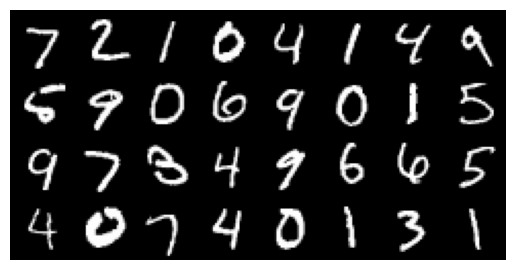

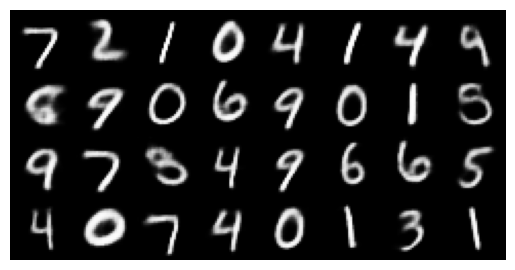

In [7]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load("./CW_VAE/VAE_model.pth", map_location='cpu') # adding map_location='cpu' as I trained on mps
vae.eval()


# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if "weight" in params.keys():
            flag = params["weight"].ndim == 4
    return flag


has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(
    vae_denorm(vae_input),
    nrow=8,
    padding=2,
    normalize=False,
    value_range=None,
    scale_each=False,
    pad_value=0,
)
plt.figure()
plt.axis("off")
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(
    vae_denorm(vae_test),
    nrow=8,
    padding=2,
    normalize=False,
    value_range=None,
    scale_each=False,
    pad_value=0,
)
plt.figure()
plt.axis("off")
show(vae_reco)

Number of Parameters is 24673924 which is ok


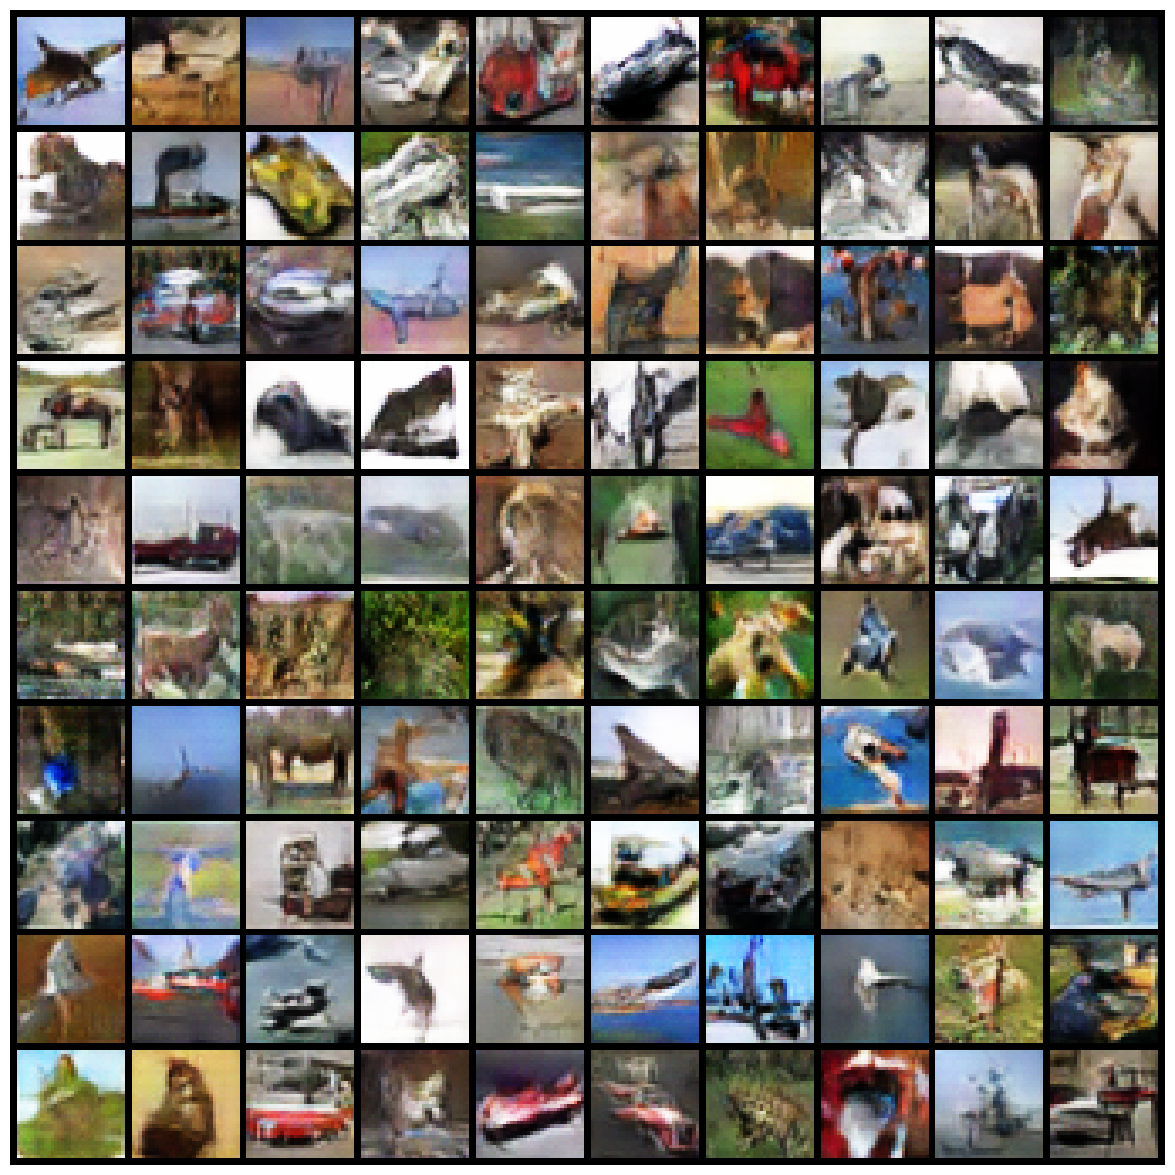

In [8]:
# GAN Tests
model_G = torch.jit.load("./CW_GAN/GAN_G_model.pth", map_location='cpu') #adding map_location='cpu' as I trained on mps
model_D = torch.jit.load("./CW_GAN/GAN_D_model.pth", map_location='cpu') #adding map_location='cpu' as I trained on mps
[model.eval() for model in (model_G, model_D)]

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(), *model_D.parameters()])

print(
    f"Number of Parameters is {num_param} which is",
    "ok" if num_param < 25e6 else "not ok",
)

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(
    gan_denorm(generated)[:100].detach(),
    nrow=10,
    padding=2,
    normalize=False,
    value_range=None,
    scale_each=False,
    pad_value=0,
)
plt.figure(figsize=(15, 15))
plt.axis("off")
show(generated)